In [495]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import euclidean_distances, jaccard_score, pairwise_distances

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64
import requests

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

sys.path.append("../../stimuli/block_utils/")
import blockworld_utils as utils

In [496]:
experiment_name = 'build_components'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(analysis_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [497]:
# plot setup
plt.rcParams["figure.figsize"] = (6,4)

In [498]:
# which iteration name should we use?
iteration_name = 'build_components_pilot_2'

### Load csvs from dataframe generator

In [499]:
df_trial = pd.read_csv(experiment_results_dir + '/df_trial_{}.csv'.format(iteration_name))

In [500]:
df_recog = df_trial[df_trial.trial_type == "block-tower-old-new"].reset_index().drop(columns=['index', 'Unnamed: 0'])

In [501]:
df_encode = df_trial[~(df_trial.trial_type == "block-tower-old-new")].reset_index().drop(columns=['index', 'Unnamed: 0'])

In [502]:
df_blocks = pd.read_csv(experiment_results_dir + '/df_blocks_{}.csv'.format(iteration_name))

## Add useful columns

### stimulus info

In [503]:
# import stim dataframes
df_towers = pd.read_csv('../../stimuli/block_utils/ambiguous/ambiguous_composite_towers.csv')

In [504]:
df_towers['tower_id'] = df_towers.tower_id_tall

In [506]:
df_recog = df_recog.merge(df_towers[['tower_id','stim_wide']], on = 'tower_id')

### Timing data

In [507]:
# df_build['trial_num'] = df_build.trial_index - 3
# df_build['trial_num']

# build_start = df_build[df_build.trial_num == 0][['gameID','trial_start_time']]
# build_start = build_start.rename(columns = {'trial_start_time': 'build_start_time'})

# build_finish = df_build[df_build.trial_num == 15][['gameID','timeAbsolute']]
# build_finish = build_finish.rename(columns= {'timeAbsolute':'build_finish_time'})
# build_timing = build_start.merge(build_finish, on='gameID')
# build_timing['build_duration'] = build_timing['build_finish_time'] - build_timing['build_start_time']
# build_timing['build_duration_min'] = build_timing['build_duration'] / (1000 * 60)
# build_timing

#### export for stats

In [508]:
save = False

if save:
    filename = '../../results/build_components/csv/df_trial_{}.csv'.format(iteration_name)
    df_trial.to_csv(filename)
    print(filename)

# Analysis 

### Analysis setup

### plot setup

In [509]:
sns.set_context('poster')
sns.set(font_scale=1.2)
sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Avenir'})

## Key analyses

### Condition difference in accuracy

In [510]:
df_recog['novelty'] = ['new' if condition == 'foil' else 'old' for condition in df_recog.condition]

In [511]:
# double check accuracy calculations
df_recog['response_correct_recalc'] = ((df_recog.response_meaning == 'new') & (df_recog.condition == 'foil')) | \
                                       ((df_recog.response_meaning == 'old') & (df_recog.condition != 'foil'))

df_recog['response_correct_recalc'].equals(df_recog['response_correct'].astype(bool))

In [513]:
df_recog.groupby('gameID')['response_correct'].mean().mean()

0.6683333333333333

(0.0, 1.0)

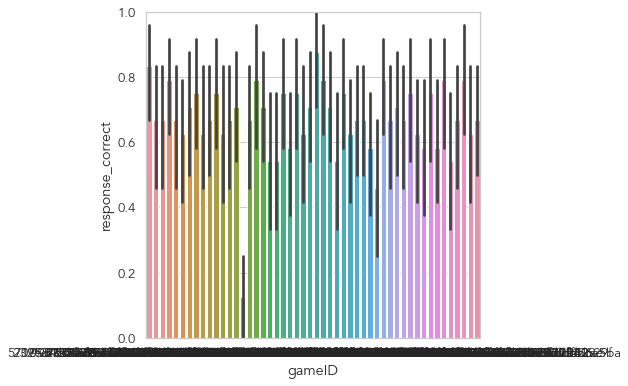

In [515]:
fig = plt.figure(figsize=(6,6))

sns.barplot(data = df_recog, 
            y = "response_correct",
            x = "gameID")
plt.ylim((0,1))

<AxesSubplot:xlabel='condition', ylabel='response_correct'>

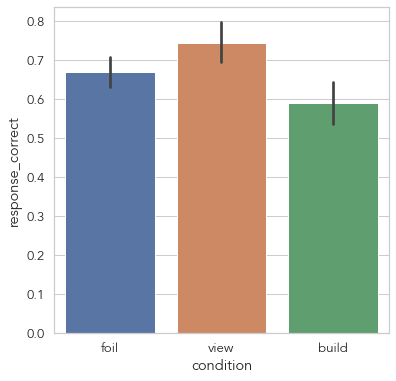

In [516]:
fig = plt.figure(figsize=(6,6))

sns.barplot(data = df_recog, 
            y = "response_correct", 
            x = "condition")

<AxesSubplot:xlabel='gameID', ylabel='response_correct'>

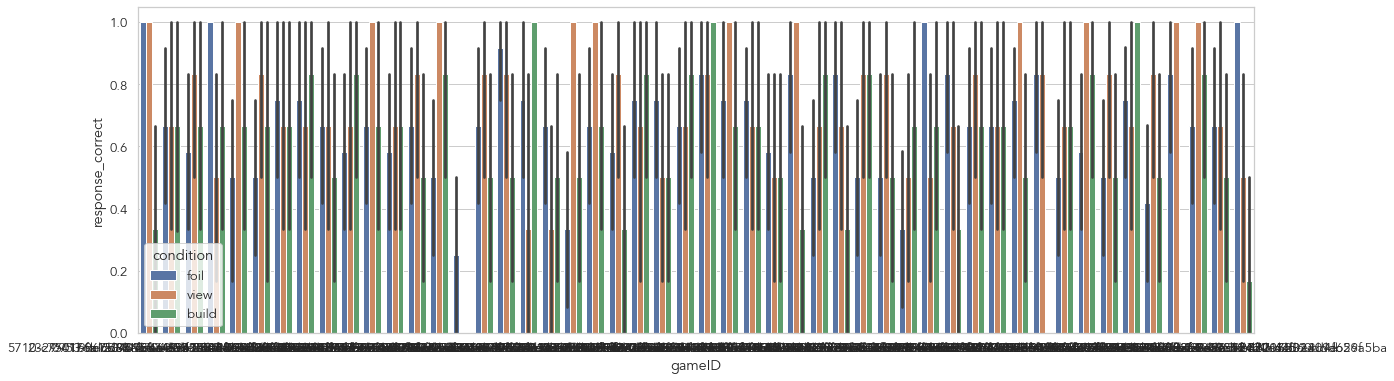

In [517]:
fig = plt.figure(figsize=(20,6))

sns.barplot(data = df_recog, 
            y = "response_correct", 
            x = "gameID",
            hue = "condition")

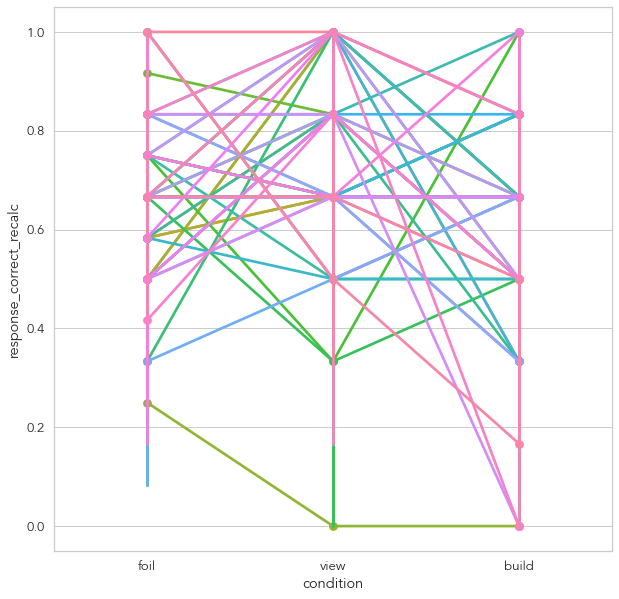

In [518]:
fig = plt.figure(figsize=(10,10))

sns.pointplot(data = df_recog, 
            y = "response_correct_recalc", 
            x = "condition",
            hue="gameID",
            legend="none")
# plt.legend(bbox_to_anchor=(1,1))
plt.legend([],[], frameon=False)


In [519]:
# visualize all responses
# df_recog.groupby('gameID').response.apply(lambda g : ''.join([x for x in g]))

### Condition difference in d'

hit rate H: proportion of YES trials to which subject responded YES =  P("yes" | YES)
false alarm rate F: proportion of NO trials to which subject responded YES  = P("yes" | NO)
d' = z(H) - z(F)


comparing d' for build and view conditions.
In each of these we can look at the hit rate.
But the false alarm rate isn't tied to the hit rate (i.e. false alarms don't have a condition).\


For each participant, for each condition:
- Hit: number of old trials to which ppt responded *old*
- Miss: number of old trials to which ppt responded *new*
- False alarm: number of new trials to which ppt responded *old*
- Correct rejection: number of new trials to which ppt responded *new*

In [520]:
def detection_measures(df_group):
    olds = df_group[df_group.novelty == 'old']
    news = df_group[df_group.novelty == 'new']
    
    # raw counts
    n_hit = len(olds[olds['response_meaning'] == 'old'])
    n_miss = len(olds[olds['response_meaning'] == 'new'])
    n_false_alarm = len(news[news['response_meaning'] == 'old'])
    n_correct_reject = len(news[news['response_meaning'] == 'new'])
    
    return pd.Series({'n_hit': n_hit,
            'n_miss' : n_miss,
            'n_false_alarm' : n_false_alarm,
            'n_correct_reject' : n_correct_reject,
            'n_old_trials' : len(olds),
            'n_new_trials': len(news)
           })

In [521]:
view_measures = df_recog[df_recog.condition.isin(['view','foil'])].groupby(['gameID']).apply(detection_measures)
build_measures = df_recog[df_recog.condition.isin(['build','foil'])].groupby(['gameID']).apply(detection_measures)

view_measures['condition'] = 'view'
build_measures['condition'] = 'build'

view_measures = view_measures.reset_index()
build_measures = build_measures.reset_index()

In [522]:
condition_measures = view_measures.append(build_measures, ignore_index=True)

In [523]:
condition_measures

gameID  n_hit  n_miss  n_false_alarm  \
0   0055-d0778fd4-bbbb-4844-83f2-e7205ae10151      4       2              4   
1   0090-2fd40afa-1888-4d40-872f-684039d135c5      5       1              2   
2   0653-f5a64817-a7eb-4b21-8cb9-2de1a2c80902      0       6              9   
3   0687-78f0cb7d-7793-4ea1-9e38-12b1cfb7c632      5       1              1   
4   0717-d8a3d2c4-639d-4895-8579-f98799c4a7f0      5       1              2   
..                                        ...    ...     ...            ...   
95  9012-5712f831-675d-4ffb-901b-3d7b6a3fc8e4      3       3              5   
96  9322-e0e5a478-a32d-4cdd-95bf-cf266b74c134      3       3              4   
97  9863-8d2f7634-ea6e-4abe-95d6-ae0ef5fa02b6      4       2              4   
98  9963-2ff0d52d-fd46-40cf-8472-587ba3ff6a77      4       2              3   
99  9967-0409bbad-ac1c-46a8-8b0b-9f9a0deff968      4       2              0   

    n_correct_reject  n_old_trials  n_new_trials condition  
0                  8             6            12      view  
1                 10             6            12      view  
2                  3             6            12      view  
3                 11             6            12      view  
4                 10             6            12      view  
..               ...           ...           ...       ...  
95                 7             6            12     build  
96                 8             6            12     build  
97                 8             6            12     build  
98                 9             6            12     build  
99                12             6            12     build  

[100 rows x 8 columns]

In [524]:
from scipy.stats import norm

Z = norm.ppf

In [525]:
def old_new_d_prime(df):
    '''
    Old trials are 'yes' trials. As in 'yes I remember this'.

    For this design, F will be the same for both conditions (build and view).
    '''
    H = df['n_hit'] / df['n_old_trials']
    
    # replace HIT rates to avoid inf d-prime
    if H == 1: 
        H = 0.9999
    if H == 0:
        H = 0.0001
    
    
    F = df['n_false_alarm'] / df['n_new_trials'] 
    
    # replace FA rates to avoid inf d-prime
    if F == 1: 
        F = 0.9999
    if F == 0: 
        F = 0.0001
    
    d_prime = Z(H) - Z(F)
    
    return d_prime

In [527]:
condition_measures['d_prime'] = condition_measures.apply(lambda row: old_new_d_prime(row), axis=1)

<AxesSubplot:xlabel='condition', ylabel='d_prime'>

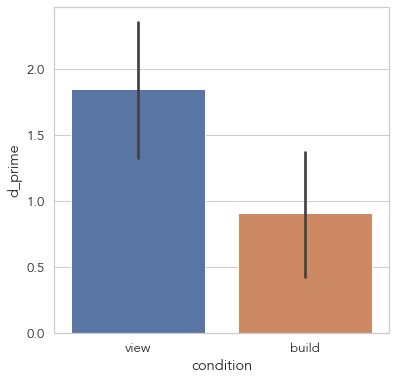

In [528]:
fig = plt.figure(figsize=(6,6))

sns.barplot(data = condition_measures, 
            y = "d_prime", 
            x = "condition")

In [529]:
condition_measures.groupby('condition')['d_prime'].mean()

condition
build    0.905926
view     1.846695
Name: d_prime, dtype: float64

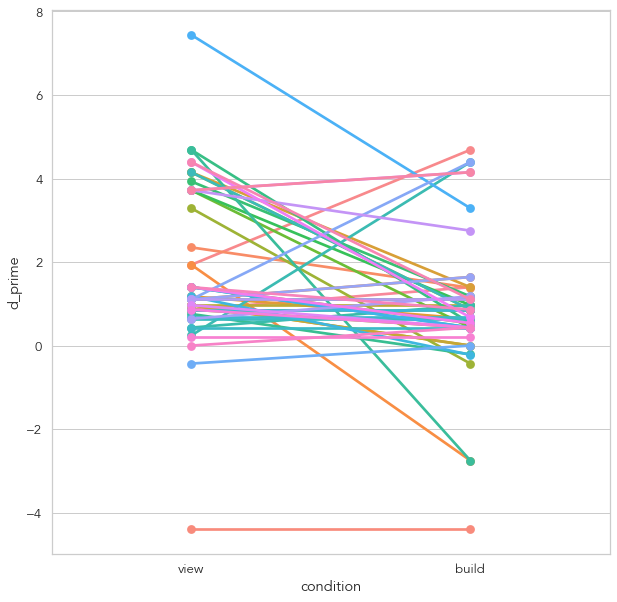

In [530]:
fig = plt.figure(figsize=(10,10))

sns.pointplot(data = condition_measures, 
            y = "d_prime", 
            x = "condition",
            hue = "gameID")

plt.legend([],[], frameon=False)

### Effect of tower

In [531]:
def show_tower(url, ax):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
#     plt.figure(figsize=(2,1))
    ax.imshow(img)
    ax.axis('off')
    
def show_tower_subplot(tower_id,
                      ax,
              url_stem = "https://zipping-composites-monochrome-png-rerender.s3.amazonaws.com/tower_4_block_unique_silhouettes_composites_monochrome_png_rerender_{}.png"):
    
    response = requests.get(url_stem.format(tower_id))
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(tower_id)
    

In [532]:
tower_ids = list(np.sort(df_recog.tower_id.unique()))

Text(0.5, 1.0, '')

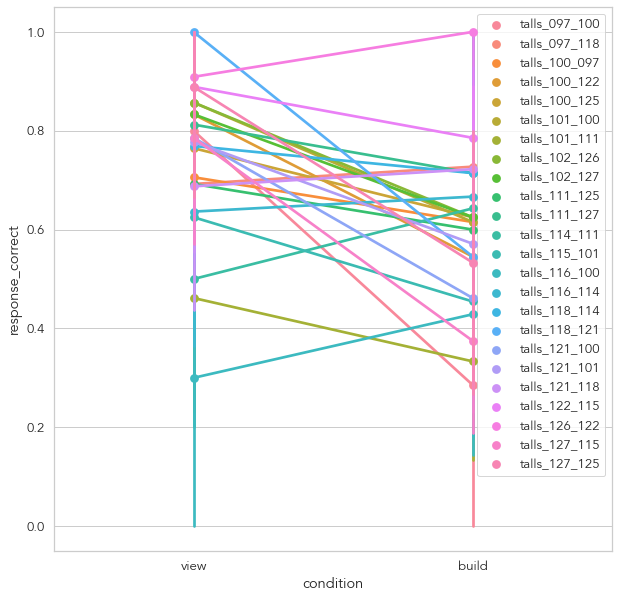

In [533]:
plt.figure(figsize = (10,10))
sns.pointplot(data = df_recog[df_recog.condition != 'foil'],
            y = 'response_correct',
            x = 'condition',
            hue = 'tower_id',
            hue_order=tower_ids)
# plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor = (1,1))

plt.title('')

No handles with labels found to put in legend.


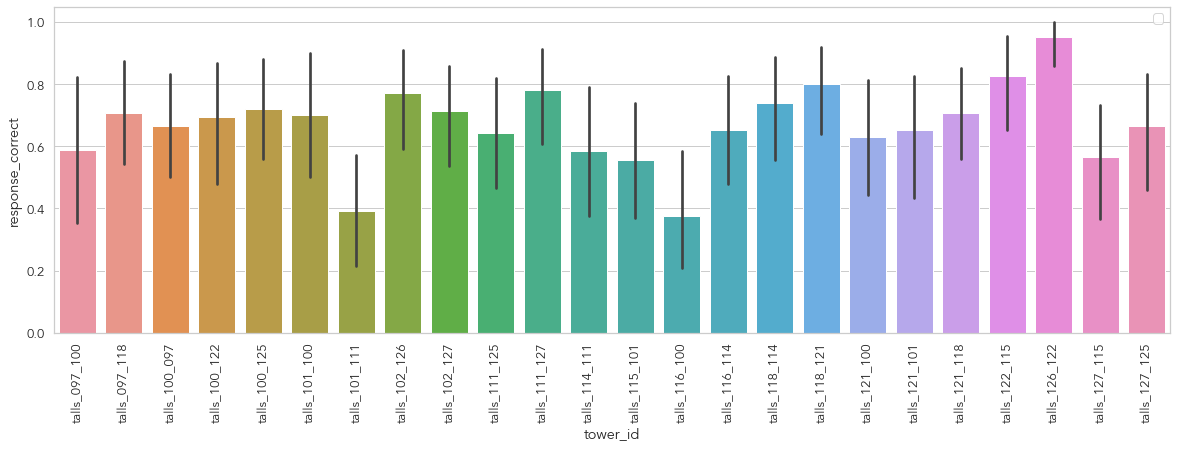

In [534]:
plt.figure(figsize = (20,6))
sns.barplot(data = df_recog[df_recog.condition != 'foil'],
            y = 'response_correct',
            x = 'tower_id',
#             hue = 'condition',
            order=tower_ids)
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor = (1,1))

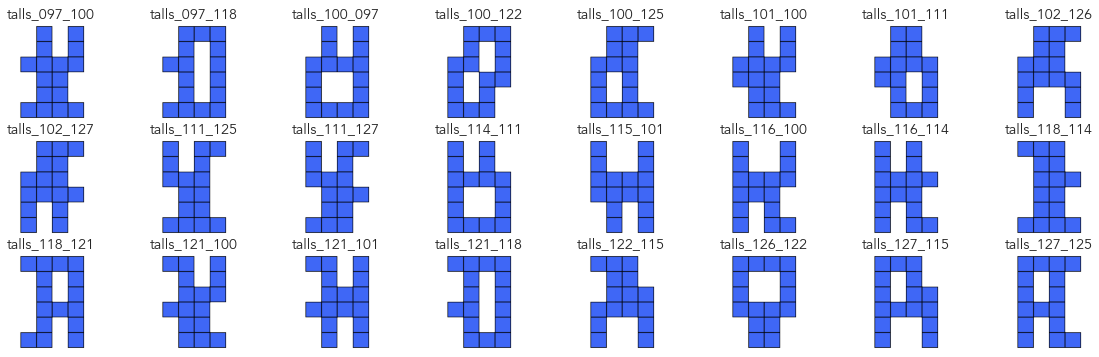

In [535]:
n_row = 3
fig, axs = plt.subplots(n_row, int(len(tower_ids)/n_row), figsize=(20,6))

for i, tower in enumerate(tower_ids):
    show_tower_subplot(tower, axs[int(np.floor(i/(len(tower_ids)/n_row))), i%(int(len(tower_ids)/n_row))])

## Building measures

#### Build time

relative_time: time between start and end of building trial. This includes *all* attempts, i.e. time including resets.

In [536]:
df_build = df_encode[df_encode.trial_type == 'block-tower-building']

In [537]:
build_times = df_build.groupby('gameID')[['relative_time']].mean().reset_index()

<AxesSubplot:xlabel='gameID', ylabel='relative_time'>

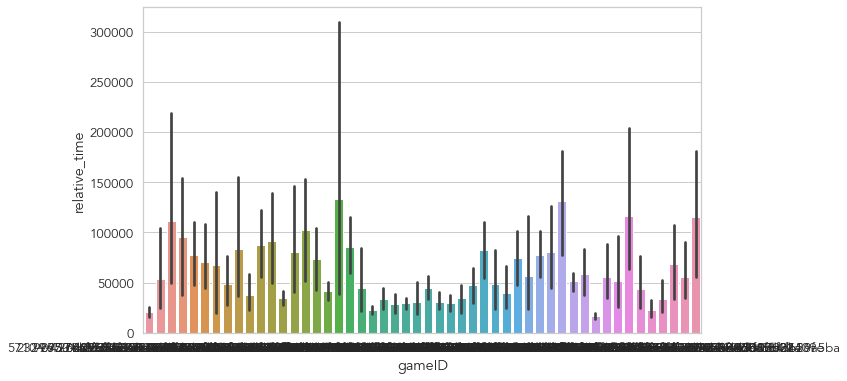

In [538]:
plt.figure(figsize =(10,6))

sns.barplot(data = df_build,
            x = 'gameID',
            y = 'relative_time',
            )

<AxesSubplot:xlabel='relative_time', ylabel='Count'>

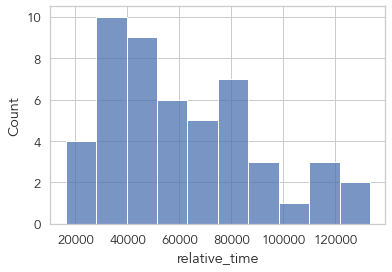

In [539]:
sns.histplot(build_times,
            x = 'relative_time',
            log_scale=False,
            bins=10)

In [540]:
build_times.mean()

<ipython-input-540-904635fd3750>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  build_times.mean()


relative_time    61080.26
dtype: float64

Average build time is a lot longer than the 15 seconds people have to view the structure. 

### Resets

In [681]:
reset_means = df_build.groupby('gameID')[['n_resets']].mean().reset_index()

<AxesSubplot:xlabel='n_resets', ylabel='Count'>

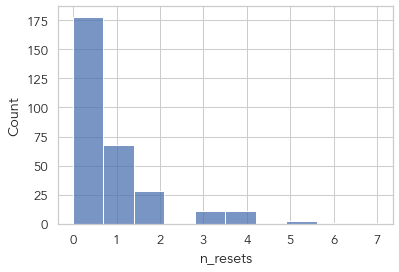

In [682]:
# raw trials
sns.histplot(df_build,
            x = 'n_resets',
            log_scale=False,
            bins=10)

<AxesSubplot:xlabel='n_resets', ylabel='Count'>

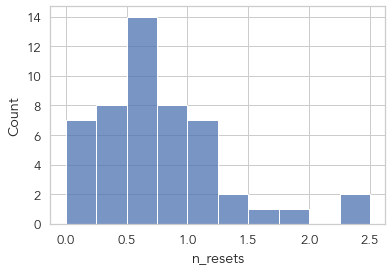

In [683]:
# mean for ppts
sns.histplot(reset_means,
            x = 'n_resets',
            log_scale=False,
            bins=10)

## Time measures

These plots seem to suggest that the longer you wait between encoding and recall, the worse your memory of that item.

In [684]:
# this dataframe contains recognition trials only from targets (i.e. non-foils)
# it is augmented with additional variables from here onwards
df_recog_target = df_recog[df_recog.condition != 'foil']

#### Encoding trial number

Were the targets that were viewed/ built later remembered better?
Looks like that may be the case.
Also looks like a slight primacy bias?

In [685]:
df_encode['encode_trial_num'] = df_encode.trial_num

In [686]:
df_recog_target = df_recog_target.merge(df_encode[df_encode.condition != 'foil']\
                                        [['gameID', 'tower_id','encode_trial_num']], 
                                        on = ['gameID','tower_id'])

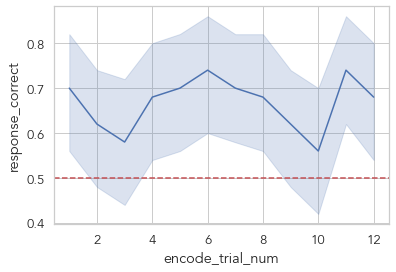

In [687]:
sns.lineplot(data = df_recog_target,
                x = 'encode_trial_num',
                y = 'response_correct')
plt.axhline(0.5, color = 'r', linestyle = '--',)

#### Recog trial number

Were the targets that were probed earlier remembered better?

In [688]:
df_recog['recog_trial_num'] = df_recog.trial_num - 12

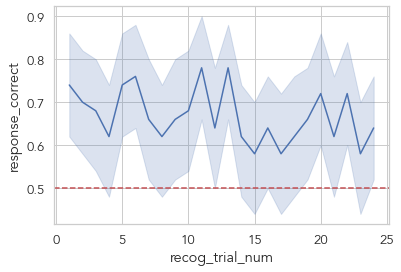

In [689]:
sns.lineplot(data = df_recog,
                x = 'recog_trial_num',
                y = 'response_correct')
plt.axhline(0.5, color = 'r', linestyle = '--',)

#### Number of trials between encoding and recognition

Were the targets with a smaller gap (number of trials) between encoding and recognition better remembered?

Eyeballing this graph it does look like the longer between encoding and recognition trials, the worse the performance.

In [690]:
def trial_diff(df, col='trial_num'):
    return df[col].max() - df[col].min()

In [691]:
trial_diffs = df_trial[df_trial.condition != 'foil'].groupby(['gameID','tower_id']).apply(trial_diff).reset_index()

In [692]:
trial_diffs = trial_diffs.rename(columns = {0: 'trial_diff'})

In [693]:
df_recog_target = df_recog_target.merge(trial_diffs, on=['gameID','tower_id'])

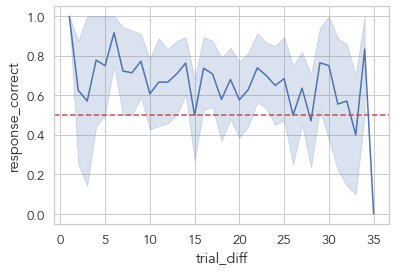

In [694]:
sns.lineplot(data = df_recog_target,
                x = 'trial_diff',
                y = 'response_correct')

plt.axhline(0.5, color = 'r', linestyle = '--',)

#### Duration between encoding and recognition

Were the targets with a smaller gap (absolute time) between encoding and recognition better remembered?

In [695]:
trial_time_diffs = df_trial[df_trial.condition != 'foil']\
    .groupby(['gameID','tower_id']).apply(lambda group: trial_diff(group, col='trial_start_time')).reset_index()

In [696]:
trial_time_diffs = trial_time_diffs.rename(columns = {0: 'trial_time_diff'})

In [697]:
df_recog_target = df_recog_target.merge(trial_time_diffs, on=['gameID','tower_id'])

In [698]:
df_recog_target['trial_time_diff_bin'] = pd.cut(df_recog_target.trial_time_diff, 10)

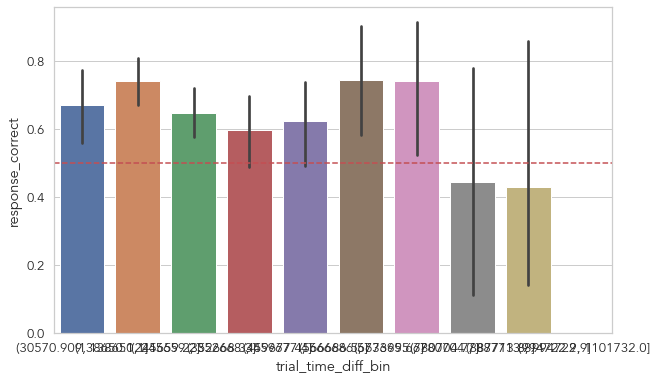

In [699]:
plt.figure(figsize=(10,6))

sns.barplot(data = df_recog_target,
                x = 'trial_time_diff_bin',
                y = 'response_correct')

plt.axhline(0.5, color = 'r', linestyle = '--',)

In [700]:
df_recog_target['trial_log_time_diff_bin'] = pd.cut(np.log(df_recog_target.trial_time_diff), 10)

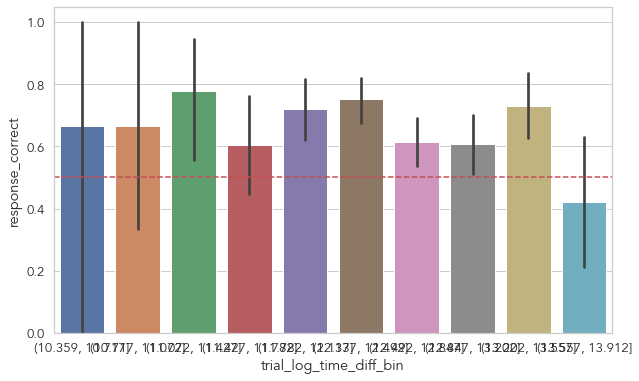

In [701]:
plt.figure(figsize=(10,6))

sns.barplot(data = df_recog_target,
                x = 'trial_log_time_diff_bin',
                y = 'response_correct')

plt.axhline(0.5, color = 'r', linestyle = '--',)

### Check for reasonable distribution of temporal differences between conditions

In [716]:
df_condition_means = df_recog_target.groupby(['gameID','condition']).mean().reset_index()

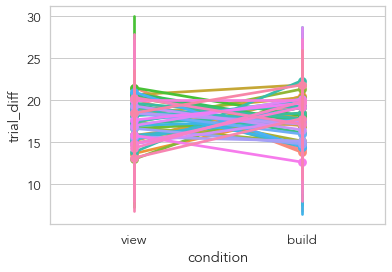

In [703]:
sns.pointplot(data = df_recog_target,
            x = 'condition',
            y = 'trial_diff',
            hue = 'gameID')
plt.legend([],[], frameon=False)

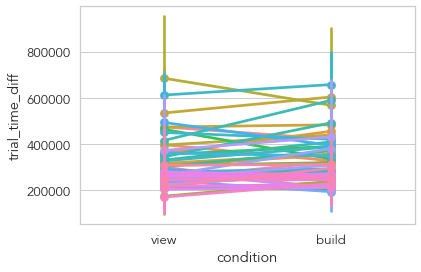

In [719]:
sns.pointplot(data = df_recog_target,
            x = 'condition',
            y = 'trial_time_diff',
            hue = 'gameID')
plt.legend([],[], frameon=False)

In [706]:
def condition_diff(df, cols = ['d_prime']):
    '''
    Returns difference between build and view conditions for variables in cols
    '''
#     print(df.condition)
    
    diffs = df[df.condition=='view'][cols].iloc[0] - df[df.condition=='build'][cols].iloc[0] 
    
    
    diffs = diffs.rename({col : col + '_diff' for col in cols})
    
    return diffs

In [727]:
# used below as predictor of d' differences
condition_time_diffs = df_condition_means.groupby(['gameID']).apply(lambda df: condition_diff(df, cols = ['trial_diff',
                                                                                   'recog_trial_num' ,
                                                                                   'encode_trial_num',
                                                                                   'trial_time_diff']))

## Explore reasons for larger differences in d' between view and build

In [729]:
condition_measures_diffs = condition_measures_expanded.groupby('gameID').apply(condition_diff)

In [730]:
ppt_accuracy = df_recog.groupby('gameID')[['response_correct']].mean().reset_index()

In [731]:
condition_measures_diffs = condition_measures_diffs.copy().merge(ppt_accuracy, on='gameID')\
                                                   .merge(build_times, on='gameID')\
                                                   .merge(reset_means, on='gameID')\
                                                   .merge(condition_time_diffs, on = 'gameID')

In [732]:
condition_measures_diffs

gameID  d_prime_diff  response_correct  \
0   0055-d0778fd4-bbbb-4844-83f2-e7205ae10151     -0.536694          0.708333   
1   0090-2fd40afa-1888-4d40-872f-684039d135c5     -2.751595          0.875000   
2   0653-f5a64817-a7eb-4b21-8cb9-2de1a2c80902      0.000000          0.125000   
3   0687-78f0cb7d-7793-4ea1-9e38-12b1cfb7c632      0.967422          0.791667   
4   0717-d8a3d2c4-639d-4895-8579-f98799c4a7f0      4.686438          0.625000   
5   0749-c3d79b55-75ae-425d-9f3d-cbaab6718589     -0.536694          0.750000   
6   0953-ddcb856a-a699-47a3-8f7d-700ee645c217      0.536694          0.666667   
7   1499-fc108b72-fd66-4924-955f-d7017b01409e      2.751595          0.791667   
8   1642-2aa7cfec-1f16-4800-bc72-f624fc299a74      0.967422          0.583333   
9   1907-16ede4a4-7b27-4077-bc0d-8aba40333924      0.967422          0.583333   
10  2177-d3b31a6d-3c78-4a5a-94d1-d5755d116f93      0.000000          0.666667   
11  2329-4176a153-b15a-4d39-a8e0-1744da902629      0.000000          0.666667   
12  2509-7f0dd7b0-97fc-4e66-a989-c7b3a069ba40      3.288289          0.750000   
13  2573-d891f721-9a77-4d8d-8261-a21ecc6a4a9f      3.719016          0.541667   
14  2577-60ef1a1f-5beb-4294-9890-313fa7f364aa      0.430727          0.625000   
15  2763-5fbf1f77-39a4-4821-8651-579fe2884f49      0.861455          0.666667   
16  2794-f6f0ee0b-000f-4cc1-89ed-e562cd61f3e2      3.288289          0.666667   
17  2834-a1c74060-0e56-4a05-91b8-5eb897b961a4      0.000000          0.708333   
18  2872-692b2ec2-5211-42e3-a1a9-b9531a155e22      2.751595          0.708333   
19  2883-aaf76271-0f01-4a52-a8ce-d9602c2e8edb      2.751595          0.750000   
20  3065-447e2394-7150-4cb5-bec9-a81e23710a28      4.149744          0.750000   
21  3101-6c5a4c8c-ee94-42f6-bcfa-e5edbc822062      0.967422          0.541667   
22  3264-7cbec54a-5248-4fb7-8e8a-b74d0c6cf32a      7.438033          0.666667   
23  3345-41786d65-25d5-4366-8b3e-00d9bf4f9193      0.967422          0.666667   
24  3417-9f56e30c-605b-436a-8427-7cae3348b9cd     -0.536694          0.625000   
25  3458-2d9df840-5996-4a66-ac26-54cc4e4197e6     -4.149744          0.708333   
26  3662-76ff047b-e90b-442c-ae0b-2fe1eb109da1      3.288289          0.750000   
27  3806-82064de5-b67c-4f0f-8e47-d90867077a5a      0.000000          0.625000   
28  3963-3a1fc061-b0b1-4aaa-affc-51058990d8f8      0.000000          0.583333   
29  4061-63b9cdf1-993d-4df5-bed5-5efba4b00cd0      0.000000          0.625000   
30  4529-299e3d30-99ed-4283-95f2-9cae184b2b86      0.000000          0.666667   
31  5551-6b4c66ec-d96b-40c0-9e36-1e16516fbfd1      1.398149          0.583333   
32  5669-979c82c8-7b36-4a71-970b-d30ab10c1ff8      0.967422          0.666667   
33  5710-c7501bfa-6d81-4c46-8961-da27b7d03c45      4.149744          0.833333   
34  6084-f35f7e9c-60ab-4896-86fd-1f85140c9364     -0.430727          0.458333   
35  6449-963fbef2-bf9e-43cc-ad1a-cc5692c927f4     -3.288289          0.791667   
36  6570-5e48e4cf-45a6-431e-a1ac-ebf2de10f370     -0.536694          0.750000   
37  6609-cf2f0909-c6bd-40e3-b7ca-825d0ad231a8     -0.536694          0.666667   
38  7090-9c20d1d3-ddd2-409c-bb44-05b1ee4f0046      0.000000          0.708333   
39  7923-8988e1b1-9da6-4d42-bd2d-e3d4fb56a5ba      0.967422          0.666667   
40  8036-80286616-548e-486a-b43f-82d4ab63f643     -0.430727          0.791667   
41  8127-a42df35b-ef39-43df-b35c-75ba97391471      0.536694          0.625000   
42  8494-ff6c6c9f-3e68-4442-9c95-dc937c963b9c      3.719016          0.750000   
43  8668-4946cb69-c0a2-4226-9a2b-cdbb3dc87112      0.861455          0.666667   
44  8971-9401b0bf-9e67-48c3-b467-44560ddd629f      0.430727          0.625000   
45  9012-5712f831-675d-4ffb-901b-3d7b6a3fc8e4      0.000000          0.541667   
46  9322-e0e5a478-a32d-4cdd-95bf-cf266b74c134     -0.430727          0.541667   
47  9863-8d2f7634-ea6e-4abe-95d6-ae0ef5fa02b6      0.536694          0.708333   
48  9963-2ff0d52d-fd46-40cf-8472-587ba3ff6a77      3.288289          0

#### distribution of differences in d' between conditions.
Positive difference indicates that d' was greater for view condition

<AxesSubplot:xlabel='d_prime_diff', ylabel='Count'>

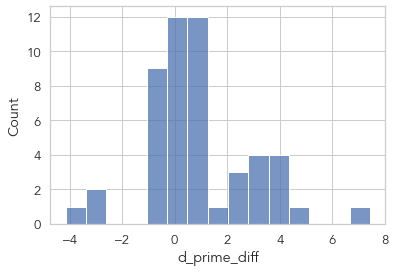

In [715]:
sns.histplot(condition_measures_diffs.d_prime_diff, bins=15)

#### Temporal differences

<AxesSubplot:xlabel='trial_diff_diff', ylabel='d_prime_diff'>

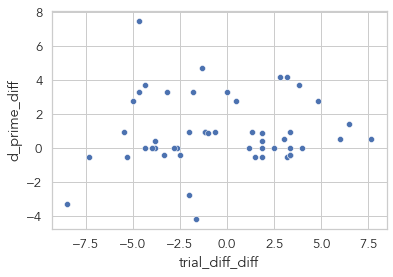

In [734]:
# average number of trials between encoding and recognition
sns.scatterplot(data = condition_measures_diffs,
                x = 'trial_diff_diff',
                y = 'd_prime_diff')

<AxesSubplot:xlabel='trial_time_diff_diff', ylabel='d_prime_diff'>

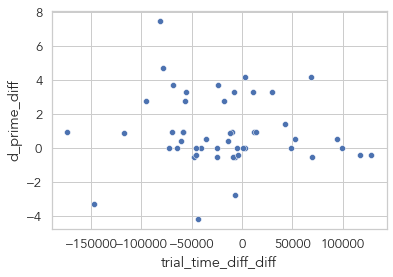

In [735]:
# average time between encoding and recognition
sns.scatterplot(data = condition_measures_diffs,
                x = 'trial_time_diff_diff',
                y = 'd_prime_diff')

<AxesSubplot:xlabel='encode_trial_num_diff', ylabel='d_prime_diff'>

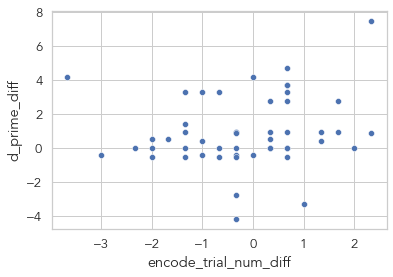

In [736]:
# are encoding trials just later for view condition? Nope
sns.scatterplot(data = condition_measures_diffs,
                x = 'encode_trial_num_diff',
                y = 'd_prime_diff')

<AxesSubplot:xlabel='recog_trial_num_diff', ylabel='d_prime_diff'>

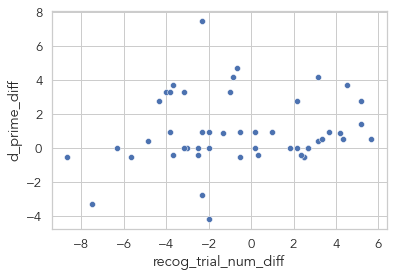

In [737]:
# are recogntion trials just earlier for view condition? Nope
sns.scatterplot(data = condition_measures_diffs,
                x = 'recog_trial_num_diff',
                y = 'd_prime_diff')

#### average build time

<AxesSubplot:xlabel='relative_time', ylabel='d_prime_diff'>

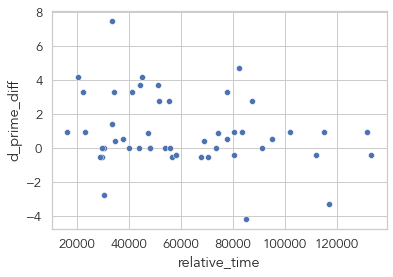

In [216]:
sns.scatterplot(data = condition_measures_diffs,
                x = 'relative_time',
                y = 'd_prime_diff')

#### average number of resets

<AxesSubplot:xlabel='n_resets', ylabel='d_prime_diff'>

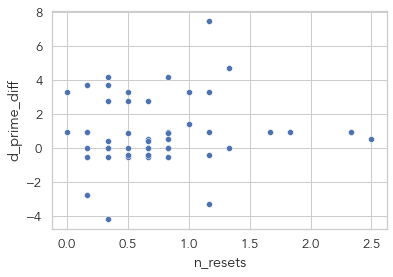

In [218]:
sns.scatterplot(data = condition_measures_diffs,
                x = 'n_resets',
                y = 'd_prime_diff')

#### average accuracy

<AxesSubplot:xlabel='response_correct', ylabel='d_prime_diff'>

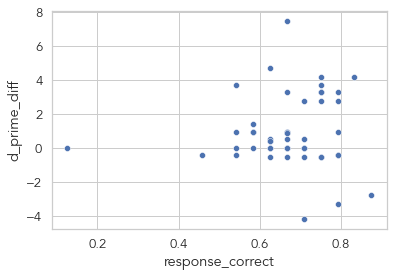

In [215]:
sns.scatterplot(data = condition_measures_diffs,
                x = 'response_correct',
                y = 'd_prime_diff')

## Kinds of errors

#### More likely to make mistake if built/ viewed chunk?

Lots of these towers shared parts (i.e. top or bottom half) with other towers. Are people more likely to false alarm if they have:
- viewed a shared part previously
- built a shared part previously
- built or viewed a shared part previously
- built or viewed a shared part more times (i.e. ordinal predictor)

In [143]:
# df_parts = \
#     df_recog.groupby(['gameID','condition'])['tower_A_wide_id'].apply(pd.unique).reset_index().merge(\
#     df_recog.groupby(['gameID','condition'])['tower_B_wide_id'].apply(pd.unique).reset_index(), 
#     on = ['gameID','condition'])


# df_parts.apply(lambda row: (list(row['tower_A_wide_id']) + list(row['tower_B_wide_id'])), axis = 1)

In [144]:
# which parts have been seen before?
old_part_bottom = df_recog.groupby(['gameID','condition']).apply(lambda row: list(pd.unique(row['tower_A_wide_id']))).reset_index()
old_part_top = df_recog.groupby(['gameID','condition']).apply(lambda row: list(pd.unique(row['tower_B_wide_id']))).reset_index()
old_part_either = df_recog.groupby(['gameID','condition']).apply(\
                lambda row: list(pd.unique(row['tower_A_wide_id'].append(row['tower_B_wide_id'])))).reset_index()

In [122]:
# careful here: you can view and build only one of the parts (don't just sum these)
# (but you can sum them to find number of times that part was built for familiarity)
n_parts_viewed = ...
n_parts_built = ...

n_times_part_seen = 0 # calculated differently! not with unique used above



In [145]:
df_recog.n_parts_built()

AttributeError: 'DataFrame' object has no attribute 'n_parts_built'

In [147]:
df_recog

_id  trial_start_time  trial_finish_time condition  \
0     637e7c93c178f27685c4f6b0      1.669234e+12       1.669234e+12      foil   
1     637e7c97c178f27685c4f6b2      1.669234e+12       1.669234e+12      foil   
2     637e7ca1c178f27685c4f6b7      1.669234e+12       1.669234e+12      view   
3     637e7ca7c178f27685c4f6bc      1.669234e+12       1.669234e+12      view   
4     637e7cacc178f27685c4f6c0      1.669234e+12       1.669234e+12      foil   
...                        ...               ...                ...       ...   
1195  637ea9a9c178f27685c50ea5      1.669245e+12       1.669245e+12     build   
1196  637ea9afc178f27685c50ea6      1.669245e+12       1.669245e+12      foil   
1197  637ea9b6c178f27685c50ea7      1.669245e+12       1.669245e+12      foil   
1198  637ea9bbc178f27685c50ea8      1.669245e+12       1.669245e+12      view   
1199  637ea9c1c178f27685c50ea9      1.669245e+12       1.669245e+12      foil   

                                               stimulus response  trial_num  \
0     {'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...        z         13   
1     {'blocks': [{'x': 1, 'y': 0, 'height': 2, 'wid...        z         14   
2     {'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...        m         15   
3     {'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...        m         16   
4     {'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...        z         17   
...                                                 ...      ...        ...   
1195  {'blocks': [{'x': 1, 'y': 0, 'height': 2, 'wid...        z         32   
1196  {'blocks': [{'x': 1, 'y': 0, 'height': 2, 'wid...        z         33   
1197  {'blocks': [{'x': 1, 'y': 0, 'height': 2, 'wid...        z         34   
1198  {'blocks': [{'x': 0, 'y': 0, 'height': 2, 'wid...        z         35   
1199  {'blocks': [{'x': 0, 'y': 0, 'height': 1, 'wid...        z         36   

                                              block_str       tower_id  \
0     0000000000000000101100001010000011100000011000...  talls_111_125   
1     0000000000000000110100000101000001110000111100...  talls_121_101   
2     0000000000000000101000001010000011110000111000...  talls_116_114   
3     0000000000000000011100000110000011100000101000...  talls_100_125   
4     0000000000000000100100001001000011110000111000...  talls_116_100   
...                                                 ...            ...   
1195  0000000000000000010100000101000011110000111000...  talls_101_100   
1196  0000000000000000011000000110000011110000110100...  talls_101_111   
1197  0000000000000000110100000101000001110000111000...  talls_121_100   
1198  0000000000000000011100000110000011100000111100...  talls_102_127   
1199  0000000000000000010100000101000011110000011000...  talls_097_100   

     tower_A_tall_id  ... eventType endReason relative_time rep n_resets  \
0           tall_111  ...       NaN       NaN           NaN NaN      NaN   
1           tall_121  ...       NaN       NaN           NaN NaN      NaN   
2           tall_116  ...       NaN       NaN           NaN NaN      NaN   
3           tall_100  ...       NaN       NaN           NaN NaN      NaN   
4           tall_116  ...       NaN       NaN           NaN NaN      NaN   
...              ...  ...       ...       ...           ...  ..      ...   
1195        tall_101  ...       NaN       NaN           NaN NaN      NaN   
1196        tall_101  ...       NaN       NaN           NaN NaN      NaN   
1197        tall_121  ...       NaN       NaN           NaN NaN      NaN   
1198        tall_102  ...       NaN       NaN           NaN NaN      NaN   
1199        tall_097  ...       NaN       NaN           NaN NaN      NaN   

          rt  novelty  response_meaning response_correct key_presses  
0     6253.0      new               new              1.0         1.0  
1     2288.0      new               new              1.0         1.0  
2     7949.0      old               old              1.0         1.0  
3     4179.0      o

### Jaccard similarity

Is it harder to remember stimuli that are similar to each other?

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html

In [149]:
def get_block_map(blocks):
    return utils.worldify(ast.literal_eval(blocks)).block_map[2:,0:4]

def jaccard_distance(a, b):
    return 1 - jaccard_score(a, b, average = 'micro')

def mean_tower(group):
    return np.mean(group['square_map'])
    
def euclidean_distance(a, b):
    return math.dist(a.flatten(), b.flatten())

def euc_2(a, b):
    return np.linalg.norm(a-b)
           
def between_group_var(group_a, group_b, metric = euc_2):
    
    both_groups = group_a.copy().append(group_b.copy(), ignore_index = True)
    
    y_bar = mean_tower(both_groups)
    
    group_a_mean = mean_tower(group_a)
    group_b_mean = mean_tower(group_b)
    
    inside_sum = [(len(group_a) * ((metric(group_a_mean, y_bar))**2)), (len(group_b) * ((metric(group_b_mean, y_bar))**2))]
    
#     distances = np.array([[jaccard_distance(tower_a, tower_b) for tower_b in group_a['square_map']] for tower_a in group_b['square_map']])
    
#     squared_distances = np.square(distances)

    var = np.sum(inside_sum)
    
    return var
    

def within_group_var(group_a, group_b, metric = euc_2):
    
    total_observations = len(group_a) + len(group_b)
    
    group_vars = []
    
    for group in [group_a, group_b]:
        
        group_mean = mean_tower(group)

        errors = group['square_map'].apply(lambda tower: metric(tower, group_mean))
        
        sqrd_errors = np.square(errors)

        sum_sqrd_errors = np.sum(sqrd_errors)
        
        group_var = sum_sqrd_errors/(total_observations - 2) # 2 is number of groups
        
        group_vars.append(group_var)
    
    sum_vars = sum(group_vars)
    
    return sum_vars


def get_variabilities(df):
    
    # group contains recall trials from a single ppt
    
    build_group = df[df.condition == 'build']
    view_group  = df[df.condition == 'view']
    foil_group  = df[df.condition == 'foil']
    
    group_variabilities = {
        'build_between_group_var' : between_group_var(build_group, foil_group),
        'build_within_group_var' : within_group_var(build_group, foil_group),
        'view_between_group_var'  : between_group_var(view_group, foil_group),
        'view_within_group_var'  : within_group_var(view_group, foil_group),
    }
    
    group_variabilities['build_f_ratio'] = group_variabilities['build_between_group_var'] / group_variabilities['build_within_group_var']
    group_variabilities['view_f_ratio'] = group_variabilities['view_between_group_var'] / group_variabilities['view_within_group_var']
    
    return pd.Series(group_variabilities)

### Euclidean Distance

In [156]:
euc_2(df_recog['square_map'][0], df_recog['square_map'][100])

2.449489742783178

In [157]:
df_variabilities = df_recog.groupby(['gameID']).apply(get_variabilities).reset_index()

In [158]:
# tidy dataframe
build_variabilities = df_variabilities[['build_between_group_var','build_within_group_var','build_f_ratio','gameID']].copy()
build_variabilities['condition'] = 'build'
view_variabilities = df_variabilities[['view_between_group_var','view_within_group_var','view_f_ratio','gameID']].copy()
view_variabilities['condition'] = 'view'

build_variabilities = build_variabilities.rename(columns = {'build_between_group_var': 'between_group_var',
                                      'build_within_group_var': 'within_group_var',
                                      'build_f_ratio': 'f_ratio'})

view_variabilities = view_variabilities.rename(columns = {'view_between_group_var': 'between_group_var',
                                     'view_within_group_var': 'within_group_var',
                                     'view_f_ratio': 'f_ratio'})

df_variabilities_tidy = build_variabilities.append(view_variabilities, ignore_index=True)
df_variabilities_tidy['measure'] = 'euclidean'
df_variabilities_tidy

between_group_var  within_group_var   f_ratio  \
0            7.555556          4.854167  1.556509   
1            3.277778          5.197917  0.630595   
2           10.166667          4.864583  2.089936   
3            3.611111          5.114583  0.706042   
4            8.000000          4.979167  1.606695   
..                ...               ...       ...   
95           6.111111          5.000000  1.222222   
96           4.388889          5.114583  0.858113   
97           3.500000          5.135417  0.681542   
98           4.222222          5.229167  0.807437   
99           3.944444          5.156250  0.764983   

                                       gameID condition    measure  
0   0055-d0778fd4-bbbb-4844-83f2-e7205ae10151     build  euclidean  
1   0090-2fd40afa-1888-4d40-872f-684039d135c5     build  euclidean  
2   0653-f5a64817-a7eb-4b21-8cb9-2de1a2c80902     build  euclidean  
3   0687-78f0cb7d-7793-4ea1-9e38-12b1cfb7c632     build  euclidean  
4   0717-d8a3d2c4-639d-4895-8579-f98799c4a7f0     build  euclidean  
..                                        ...       ...        ...  
95  9012-5712f831-675d-4ffb-901b-3d7b6a3fc8e4      view  euclidean  
96  9322-e0e5a478-a32d-4cdd-95bf-cf266b74c134      view  euclidean  
97  9863-8d2f7634-ea6e-4abe-95d6-ae0ef5fa02b6      view  euclidean  
98  9963-2ff0d52d-fd46-40cf-8472-587ba3ff6a77      view  euclidean  
99  9967-0409bbad-ac1c-46a8-8b0b-9f9a0deff968      view  euclidean  

[100 rows x 6 columns]

# Export condition measures csvs

In [209]:
condition_measures_expanded = condition_measures.copy().merge(df_variabilities_tidy, on = ['gameID','condition'])

In [210]:
condition_measures_expanded.to_csv('../../results/build_components/csv/df_condition_measures_{}.csv'.format(iteration_name))

In [166]:
df_recog.to_csv('../../results/build_components/csv/df_recog_{}.csv'.format(iteration_name))

<AxesSubplot:xlabel='f_ratio', ylabel='d_prime'>

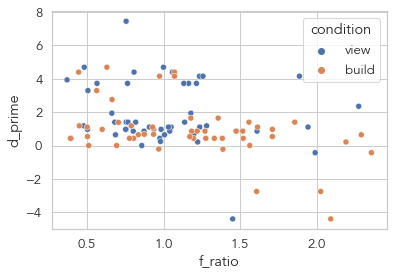

In [167]:
sns.scatterplot(
    data = condition_measures_export,
    x = 'f_ratio',
    y = 'd_prime',
    hue = 'condition'
)

### Other

### Other

### Other

# Jaccard similarity calculated incorrectly, using distances between towers

In [1103]:
def get_block_map(blocks):
    return utils.worldify(ast.literal_eval(blocks)).block_map[2:,0:4]

def jaccard_distance(a, b):
    return 1 - jaccard_score(a, b, average = 'micro')
    
def get_variance(group, metric = jaccard):
    
    distances_double_counted = np.array([[jaccard_distance(tower_a, tower_b) for tower_b in group['square_map']] for tower_a in group['square_map']])
#     print(distances_double_counted)
    distances_flat = distances_double_counted[np.tril_indices(len(group), -1)]
#     print(distances_flat)
    squared_distances = np.square(distances_flat)
#     print(squared_distances)
    sum_squared_distances = np.sum(squared_distances)
#     print(sum_squared_distances)
    var = sum_squared_distances/(len(group)**2)

    return var

def between_group_var(group_a, group_b, metric = jaccard):
    
    distances = np.array([[jaccard_distance(tower_a, tower_b) for tower_b in group_a['square_map']] for tower_a in group_b['square_map']])
    
    squared_distances = np.square(distances)

    sum_squared_distances = np.sum(squared_distances)
    
    # CHECK: dividing by two as we do in within_group_var
    var = sum_squared_distances / (2*(len(group_a)*len(group_b)))
    
    return var
    
    
def within_group_var(groups, metric = jaccard):
    
    group_vars = []
    
    for group in groups:

        distances = np.array([[jaccard_distance(tower_a, tower_b) for tower_b in group['square_map']] for tower_a in group['square_map']])

        squared_distances = np.square(distances) 

        sum_squared_distances = np.sum(squared_distances)

        # divided by two as double counting distances (alternative is to only count distances once i.e. lower triangle of distances)
        var = sum_squared_distances / (2*(len(group)**2))
        
        group_vars.append(var)
    
    # CHECK: just summing these?
    sum_vars = sum(group_vars)
    
    return sum_vars


def get_variabilities(group):
    
    # group contains recall trials from a single ppt
    
    build_group = group[group.condition == 'build']
    view_group  = group[group.condition == 'view']
    foil_group  = group[group.condition == 'foil']
    
    group_variabilities = {
        'build_between_group_var' : between_group_var(build_group, foil_group),
        'build_within_group_var' : within_group_var([build_group, foil_group]),
        'view_between_group_var'  : between_group_var(view_group, foil_group),
        'view_within_group_var'  : within_group_var([view_group, foil_group]),
    }
    
    group_variabilities['build_f_ratio'] = group_variabilities['build_between_group_var'] / group_variabilities['build_within_group_var']
    group_variabilities['view_f_ratio'] = group_variabilities['view_between_group_var'] / group_variabilities['view_within_group_var']
    
    return pd.Series(group_variabilities)


# def get_variabilities(group):
    
#     # group contains recall trials from a single ppt
    
#     exposed_group = group[group.condition.isin('build','view')]
#     foil_group  = group[group.condition == 'foil']
    
#     group_variabilities = {
#         'exposed_between_group_var' : between_group_var(exposed_group, foil_group),
#         'exposed_within_group_var' : within_group_var([exposed_group, foil_group]),
#     }
    

#     group_variabilities['exposed_f_ratio'] = group_variabilities['exposed_between_group_var'] / group_variabilities['exposed_within_group_var']
    
#     return pd.Series(group_variabilities)

In [1092]:
df_variabilities = df_recog.groupby(['gameID']).apply(get_variabilities).reset_index()

In [1097]:
# tidy dataframe
build_variabilities = df_variabilities[['build_between_group_var','build_within_group_var','build_f_ratio','gameID']].copy()
build_variabilities['condition'] = 'build'
view_variabilities = df_variabilities[['view_between_group_var','view_within_group_var','view_f_ratio','gameID']].copy()
view_variabilities['condition'] = 'view'

build_variabilities = build_variabilities.rename(columns = {'build_between_group_var': 'between_group_var',
                                      'build_within_group_var': 'within_group_var',
                                      'build_f_ratio': 'f_ratio'})

view_variabilities = view_variabilities.rename(columns = {'view_between_group_var': 'between_group_var',
                                     'view_within_group_var': 'within_group_var',
                                     'view_f_ratio': 'f_ratio'})

df_variabilities_tidy = build_variabilities.append(view_variabilities, ignore_index=True)
df_variabilities_tidy

between_group_var  within_group_var   f_ratio  \
0            0.122959          0.195636  0.628507   
1            0.115564          0.217076  0.532370   
2            0.131742          0.188888  0.697457   
3            0.116704          0.214709  0.543542   
4            0.130549          0.205112  0.636477   
..                ...               ...       ...   
95           0.120859          0.204335  0.591472   
96           0.118785          0.214210  0.554525   
97           0.113148          0.207883  0.544289   
98           0.119016          0.215268  0.552872   
99           0.115938          0.212894  0.544579   

                                       gameID condition  
0   0055-d0778fd4-bbbb-4844-83f2-e7205ae10151     build  
1   0090-2fd40afa-1888-4d40-872f-684039d135c5     build  
2   0653-f5a64817-a7eb-4b21-8cb9-2de1a2c80902     build  
3   0687-78f0cb7d-7793-4ea1-9e38-12b1cfb7c632     build  
4   0717-d8a3d2c4-639d-4895-8579-f98799c4a7f0     build  
..                                        ...       ...  
95  9012-5712f831-675d-4ffb-901b-3d7b6a3fc8e4      view  
96  9322-e0e5a478-a32d-4cdd-95bf-cf266b74c134      view  
97  9863-8d2f7634-ea6e-4abe-95d6-ae0ef5fa02b6      view  
98  9963-2ff0d52d-fd46-40cf-8472-587ba3ff6a77      view  
99  9967-0409bbad-ac1c-46a8-8b0b-9f9a0deff968      view  

[100 rows x 5 columns]

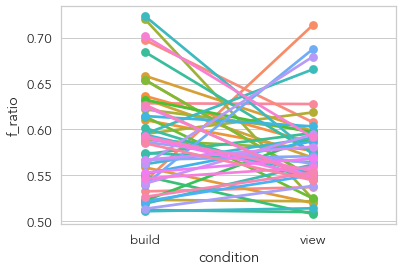

In [1099]:
sns.pointplot(data = df_variabilities_tidy,
            y = 'f_ratio',
            x = 'condition',
            hue = 'gameID',)
plt.legend([],[], frameon=False)

## Jaccard similarity (old)

Is it harder to remember stimuli that are similar to each other?

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html

In [1019]:
def get_block_map(blocks):
    return utils.worldify(ast.literal_eval(blocks)).block_map[2:,0:4]

def jaccard_distance(a, b):
    return 1 - jaccard_score(a, b, average = 'micro')
    
def get_variance(group, metric = jaccard):
    
    distances_double_counted = np.array([[jaccard_distance(tower_a, tower_b) for tower_b in group['square_map']] for tower_a in group['square_map']])
#     print(distances_double_counted)
    distances_flat = distances_double_counted[np.tril_indices(len(group), -1)]
#     print(distances_flat)
    squared_distances = np.square(distances_flat)
#     print(squared_distances)
    sum_squared_distances = np.sum(squared_distances)
#     print(sum_squared_distances)
    var = sum_squared_distances/(len(group)**2)

    return var

def variance_ratios()

SyntaxError: invalid syntax (<ipython-input-1019-7deea607cfb2>, line 21)

In [1031]:
df_recog['square_map'] = df_recog['stim_wide'].apply(lambda x: get_block_map(x))

In [1032]:
# group = df_recog[(df_recog.gameID == '5710-c7501bfa-6d81-4c46-8961-da27b7d03c45') & (df_recog.condition == 'view')]

In [1044]:
condition_variances = df_recog.groupby(['gameID', 'condition']).apply(get_variance).reset_index()\
                                                                .rename(columns = {0 : 'tower_variance'})
condition_variances

gameID condition  tower_variance
0    0055-d0778fd4-bbbb-4844-83f2-e7205ae10151     build        0.094055
1    0055-d0778fd4-bbbb-4844-83f2-e7205ae10151      foil        0.101581
2    0055-d0778fd4-bbbb-4844-83f2-e7205ae10151      view        0.093704
3    0090-2fd40afa-1888-4d40-872f-684039d135c5     build        0.105100
4    0090-2fd40afa-1888-4d40-872f-684039d135c5      foil        0.111976
..                                         ...       ...             ...
145  9963-2ff0d52d-fd46-40cf-8472-587ba3ff6a77      foil        0.114311
146  9963-2ff0d52d-fd46-40cf-8472-587ba3ff6a77      view        0.100957
147  9967-0409bbad-ac1c-46a8-8b0b-9f9a0deff968     build        0.089281
148  9967-0409bbad-ac1c-46a8-8b0b-9f9a0deff968      foil        0.111013
149  9967-0409bbad-ac1c-46a8-8b0b-9f9a0deff968      view        0.101881

[150 rows x 3 columns]

In [1045]:
# def var_ratios(row):
#     foil_var = condition_variances[(condition_variances.gameID == row['gameID']) &\
#                                    (condition_variances.condition == 'foil')]['var'].values[0]
# #     print(foil_var.values[0])
#     return (row['var'] / foil_var)

In [1046]:
# exposed_condition_variances['ratio'] = exposed_condition_variances.apply(var_ratios, axis = 1)

In [1047]:
exposed_condition_variances = condition_variances[condition_variances.condition.isin(['build','view'])].reset_index()

In [1048]:
exposed_condition_variances['tower_variance_foil'] = exposed_condition_variances.apply(\
        lambda row: condition_variances[(condition_variances.gameID == row.gameID) &\
                                        (condition_variances.condition == 'foil')]['tower_variance'].values[0], axis = 1)

exposed_condition_variances['tower_variance_ratio'] = (exposed_condition_variances['tower_variance']/exposed_condition_variances['tower_variance_foil'])
exposed_condition_variances = exposed_condition_variances.drop(columns=['index'])
exposed_condition_variances

gameID condition  tower_variance  \
0   0055-d0778fd4-bbbb-4844-83f2-e7205ae10151     build        0.094055   
1   0055-d0778fd4-bbbb-4844-83f2-e7205ae10151      view        0.093704   
2   0090-2fd40afa-1888-4d40-872f-684039d135c5     build        0.105100   
3   0090-2fd40afa-1888-4d40-872f-684039d135c5      view        0.111106   
4   0653-f5a64817-a7eb-4b21-8cb9-2de1a2c80902     build        0.080881   
..                                        ...       ...             ...   
95  9863-8d2f7634-ea6e-4abe-95d6-ae0ef5fa02b6      view        0.094811   
96  9963-2ff0d52d-fd46-40cf-8472-587ba3ff6a77     build        0.106933   
97  9963-2ff0d52d-fd46-40cf-8472-587ba3ff6a77      view        0.100957   
98  9967-0409bbad-ac1c-46a8-8b0b-9f9a0deff968     build        0.089281   
99  9967-0409bbad-ac1c-46a8-8b0b-9f9a0deff968      view        0.101881   

    tower_variance_foil  tower_variance_ratio  
0              0.101581              0.925916  
1              0.101581              0.922457  
2              0.111976              0.938595  
3              0.111976              0.992234  
4              0.108007              0.748849  
..                  ...                   ...  
95             0.113072              0.838503  
96             0.114311              0.935455  
97             0.114311              0.883175  
98             0.111013              0.804236  
99             0.111013              0.917738  

[100 rows x 5 columns]

In [1050]:
# condition_measures = condition_measures.merge(exposed_condition_variances, on = ['gameID','condition'])

# From zippins study (for reference)

## zipping trials- group level performance

<AxesSubplot:xlabel='gameID', ylabel='response_correct'>

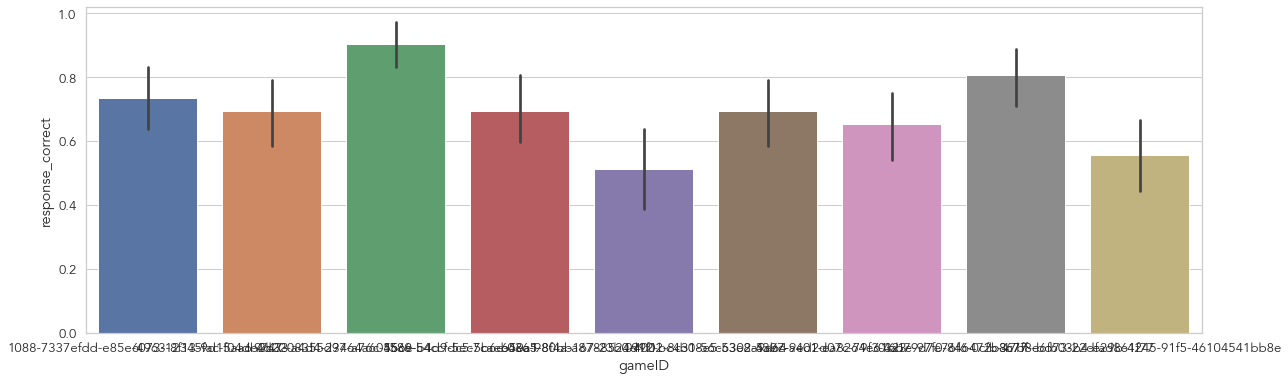

In [157]:
fig = plt.figure(figsize=(20,6))

sns.barplot(data=df_zip, 
              y= "response_correct", 
              x= "gameID",
              )

<AxesSubplot:xlabel='gameID', ylabel='rt'>

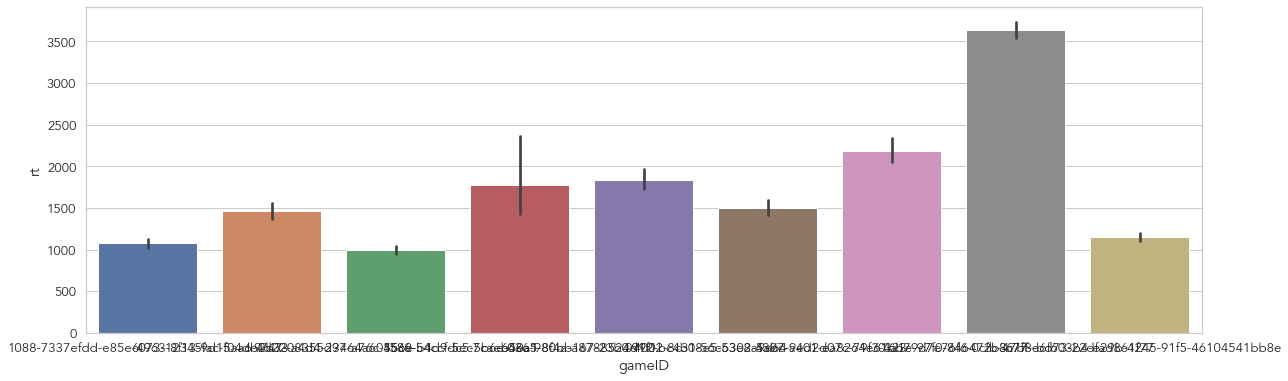

In [158]:
fig = plt.figure(figsize=(20,6))

sns.barplot(data=df_zip, 
              y= "rt", 
              x= "gameID",
              )

/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/U

Text(0.5, 0, 'log(RT)')

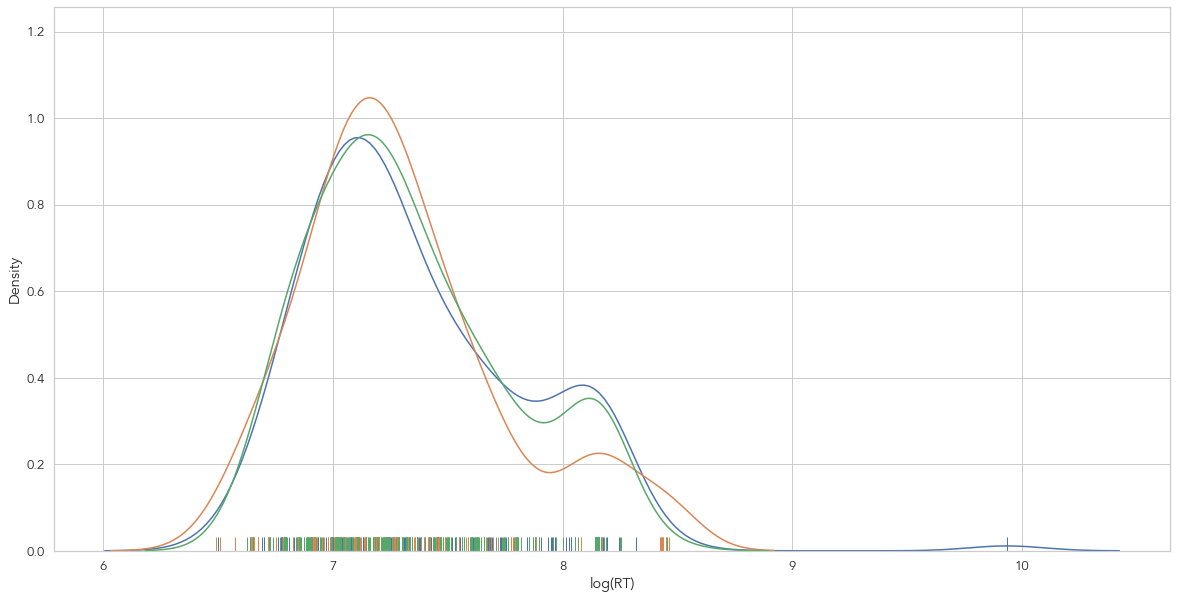

In [159]:
plt.figure(figsize=(20,10))
sns.distplot(np.log(df_zip[df_zip.compatibility == 'compatible'].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[df_zip.compatibility == 'incompatible'].rt), rug=True, hist=False)
sns.distplot(np.log(df_zip[df_zip.compatibility == 'novel'].rt), rug=True, hist=False)
plt.xlabel('log(RT)')

In [160]:
df_zip['trial_bin'] = np.floor((df_zip.trial_num) / 12)

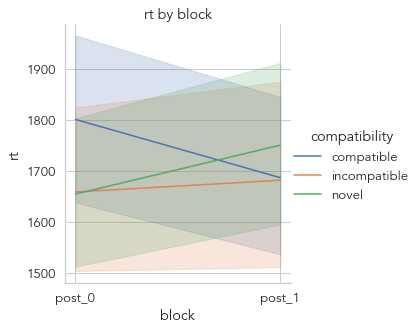

In [161]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="block",
                hue="compatibility",
                kind="line",
                height=4.6,
                aspect=1)
plt.title('rt by block')
# plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

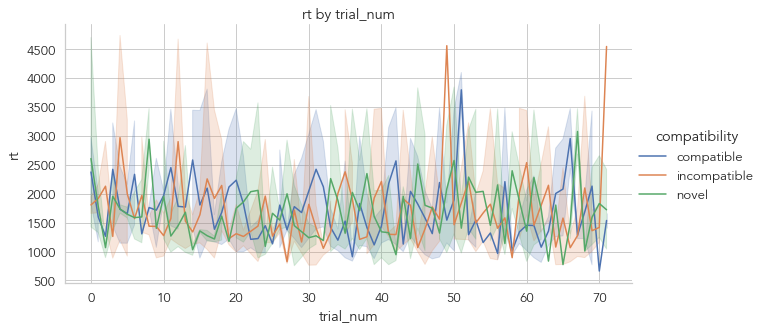

In [162]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="trial_num",
                hue="compatibility",
#                 col="trial_num",
                kind="line",
                height=4.6,
                aspect=2)
# plt.ylim(800,1500)
plt.title('rt by trial_num')
plt.show()

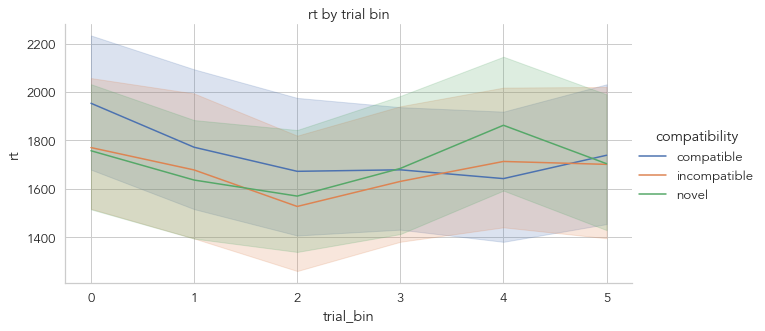

In [163]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="trial_bin",
                hue="compatibility",
#                 col="trial_num",
                kind="line",
                height=4.6,
                aspect=2)
# plt.ylim(800,1500)
plt.title('rt by trial bin')
plt.show()

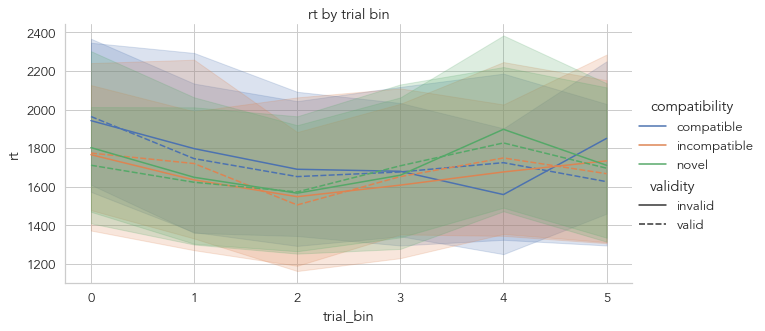

In [164]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="trial_bin",
                hue="compatibility",
                style="validity",
                kind="line",
                height=4.6,
                aspect=2)
# plt.ylim(800,1500)
plt.title('rt by trial bin')
plt.show()

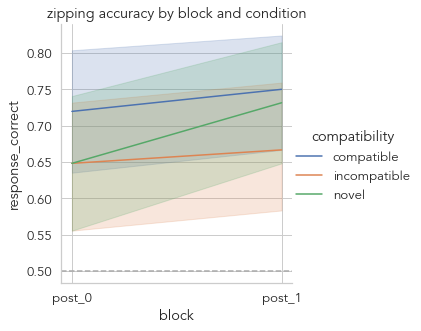

In [165]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="block",
                hue="compatibility",
                kind="line",
                height=4.6, 
                aspect=1) 
# plt.ylim(0,1)
plt.title('zipping accuracy by block and condition')
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

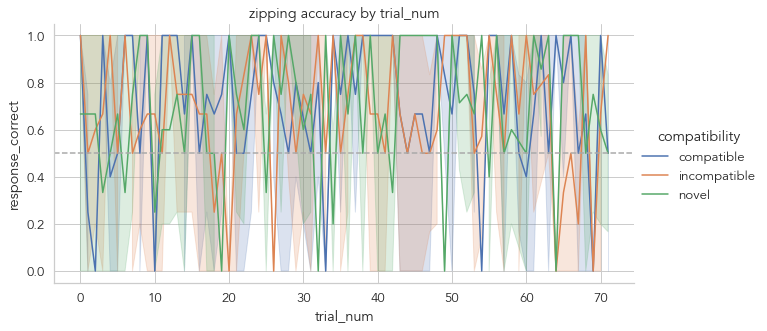

In [166]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="trial_num",
                hue="compatibility",
#                 col="trial_num",
                kind="line",
                height=4.6,
                aspect=2)

plt.title('zipping accuracy by trial_num')
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

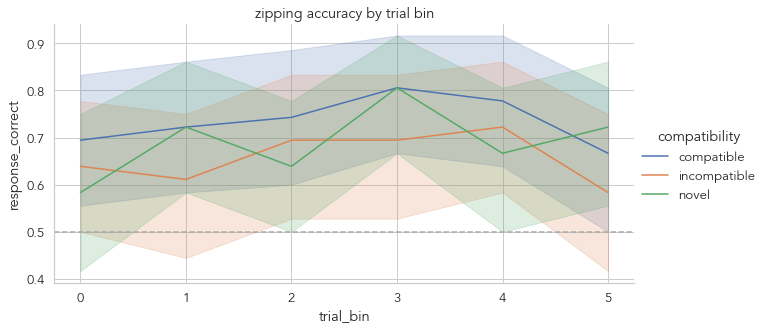

In [167]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="trial_bin",
                hue="compatibility",
#                 col="trial_num",
                kind="line",
                height=4.6,
                aspect=2)

plt.title('zipping accuracy by trial bin')
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

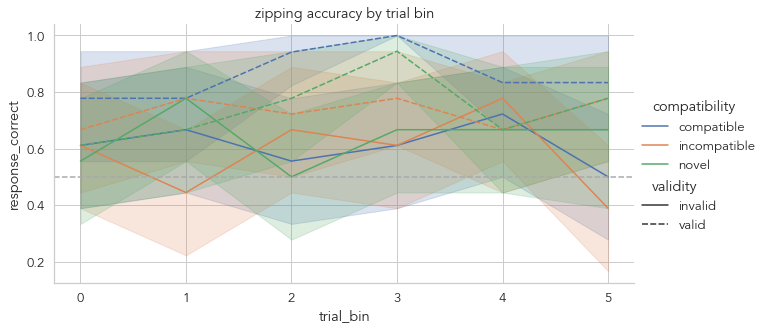

In [168]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="trial_bin",
                hue="compatibility",
                style="validity",
#                 col="trial_num",
                kind="line",
                height=4.6,
                aspect=2)

plt.title('zipping accuracy by trial bin')
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

In [90]:
df_zip.phase

0      post_zipping_trials
1      post_zipping_trials
2      post_zipping_trials
3      post_zipping_trials
4      post_zipping_trials
              ...         
643    post_zipping_trials
644    post_zipping_trials
645    post_zipping_trials
646    post_zipping_trials
647    post_zipping_trials
Name: phase, Length: 648, dtype: object

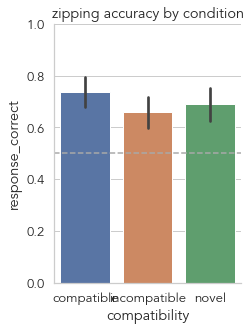

In [91]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="compatibility",
#                 col="trial_num",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
plt.title('zipping accuracy by condition')
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

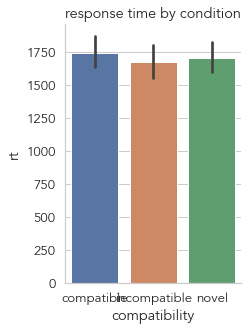

In [92]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt",
                x="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by condition')
plt.show()

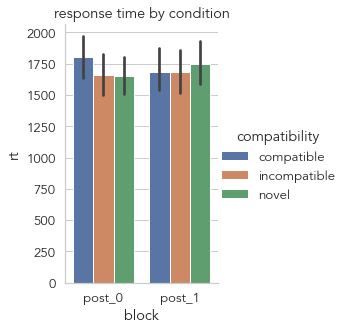

In [93]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt",
                hue="compatibility",
                x="block",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by condition')
plt.show()

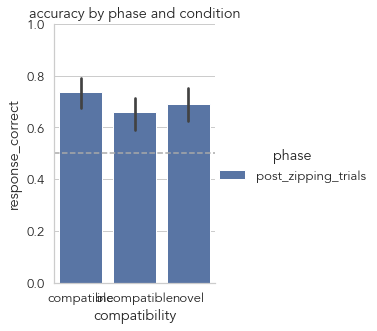

In [94]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                hue="phase",
                x="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.title('accuracy by phase and condition')
plt.show()

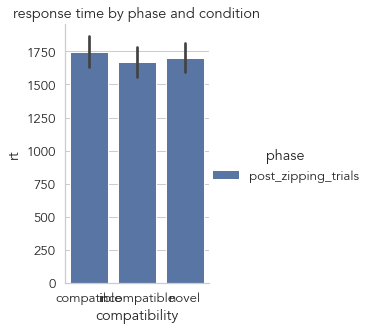

In [95]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                hue="phase",
                x="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by phase and condition')
plt.show()

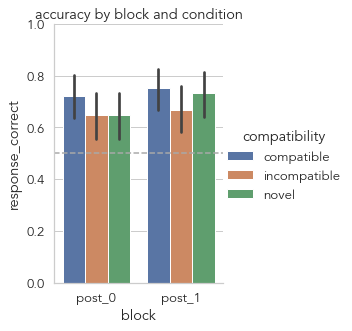

In [96]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="block",
                hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.title('accuracy by block and condition')
plt.show()

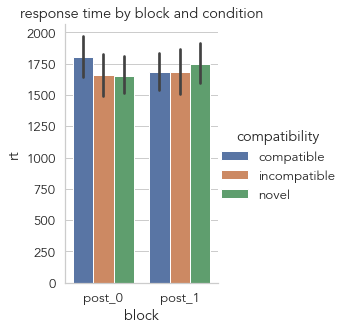

In [97]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="block",
                hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by block and condition')
plt.show()

### Validity

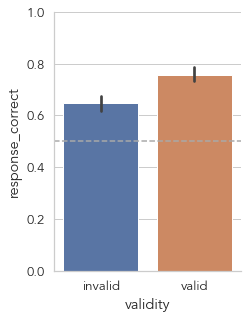

In [574]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="validity",
#                 col="trial_num",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
# plt.title('zipping accuracy by condition')
plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

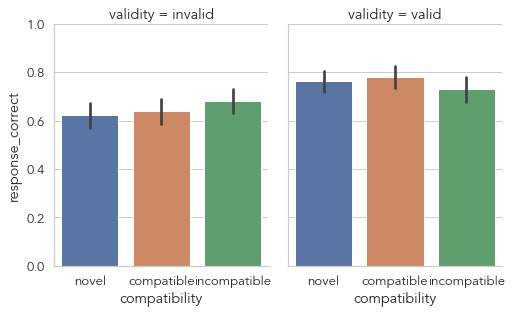

In [584]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="compatibility",
                col="validity",
#                 row="part_type",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
# plt.title('zipping accuracy by condition')
# plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

In [595]:
compatibility_order = ["novel","compatible","incompatible"]

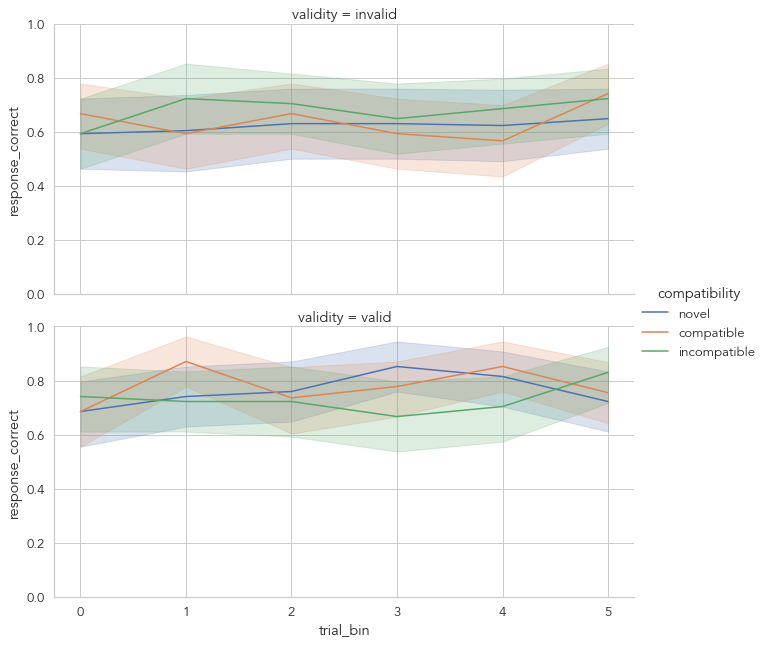

In [598]:
g = sns.relplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                hue="compatibility",
                hue_order = compatibility_order,
                row="validity",
                x="trial_bin",
#                 row="part_type",
                kind="line",
                height=4.6,
                aspect=2)
plt.ylim(0,1)
# plt.title('zipping accuracy by condition')
# plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

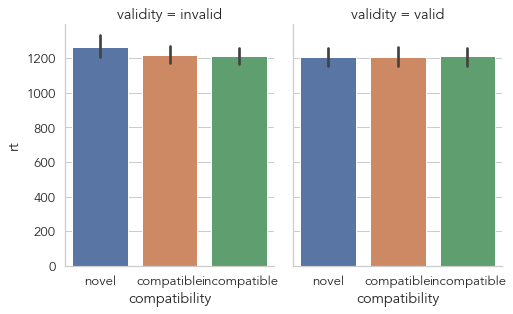

In [582]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="compatibility",
                col="validity",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
# plt.ylim(0,1)
# plt.title('zipping accuracy by condition')
# plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

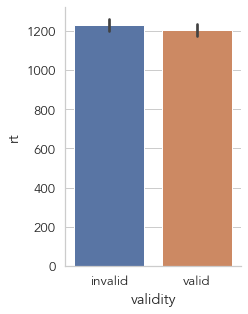

In [578]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="validity",
#                 col="trial_num",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
# plt.ylim(0,1)
# plt.title('zipping accuracy by condition')
# plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

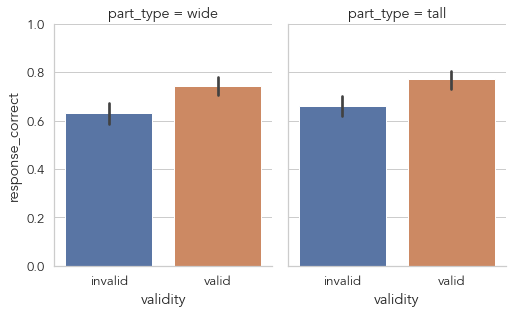

In [576]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="validity",
                col="part_type",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.ylim(0,1)
# plt.title('zipping accuracy by condition')
# plt.axhline(y=0.5, color='darkgrey', linestyle='--')
plt.show()

## Wide vs Tall

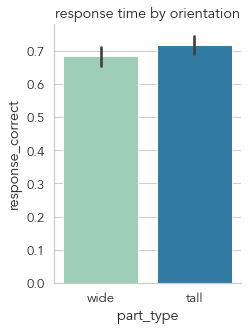

In [449]:
g = sns.catplot(data=df_zip,
                y="response_correct", 
                x="part_type",
                palette="YlGnBu",
#                 hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by orientation')
plt.show()

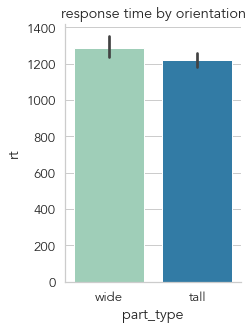

In [450]:
g = sns.catplot(data=df_zip,
                y="rt", 
                x="part_type",
#                 hue="compatibility",
                palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.title('response time by orientation')
plt.show()

## Item

In [522]:
composite_order = np.sort(df_zip.composite_id.unique())

talls_101_114


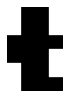

talls_102_122


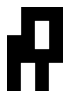

talls_111_127


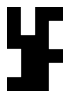

In [521]:
import requests

def show(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(1,2))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def toCompositeURL(stimID):
    stimURL = "https://zipping-composites-png-rerender.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_" + stimID + ".png"
    return(stimURL)

_ = [(print(stimID), show(toCompositeURL(stimID))) for stimID in composite_order]

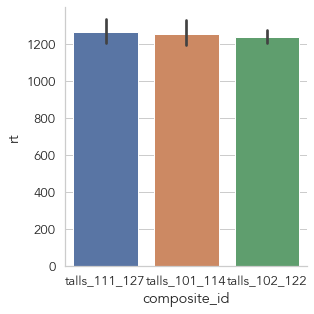

In [455]:
g = sns.catplot(data=df_zip,
#                 col="composite_id",
                y="rt", 
                x="composite_id",
#                 hue="part_type",
#                 palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

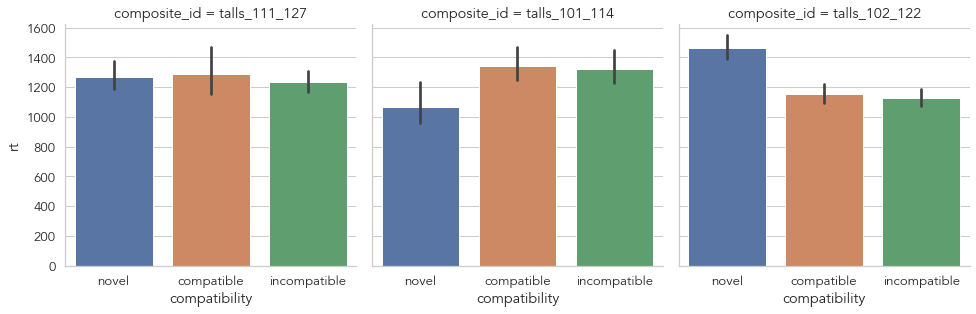

In [456]:
g = sns.catplot(data=df_zip,
                col="composite_id",
                y="rt", 
#                 hue="part_type",
                x="compatibility",
#                 palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

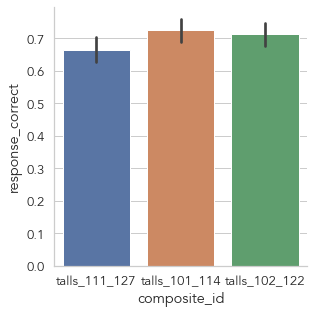

In [457]:
g = sns.catplot(data=df_zip,
#                 col="composite_id",
                y="response_correct", 
                x="composite_id",
#                 hue="part_type",
#                 palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

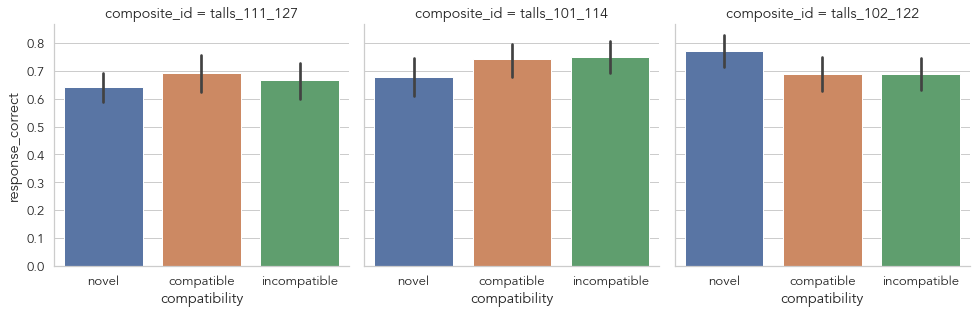

In [458]:
g = sns.catplot(data=df_zip,
                col="composite_id",
                y="response_correct", 
#                 hue="part_type",
                x="compatibility",
#                 palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

### Item by wide and tall

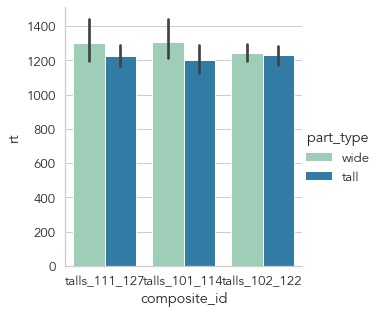

In [451]:
g = sns.catplot(data=df_zip,
#                 col="composite_id",
                y="rt", 
                x="composite_id",
                hue="part_type",
                palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

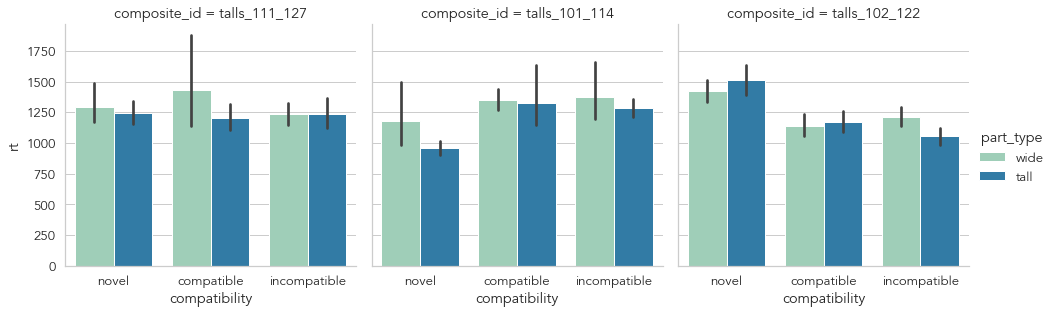

In [447]:
g = sns.catplot(data=df_zip,
                col="composite_id",
                y="rt", 
                hue="part_type",
                x="compatibility",
                palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

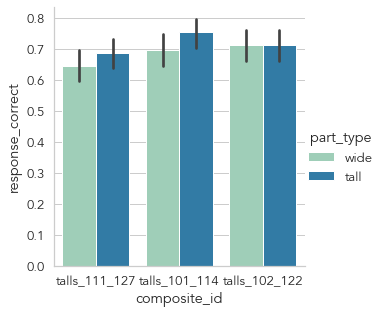

In [452]:
g = sns.catplot(data=df_zip,
#                 col="composite_id",
                y="response_correct", 
                x="composite_id",
                hue="part_type",
                palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

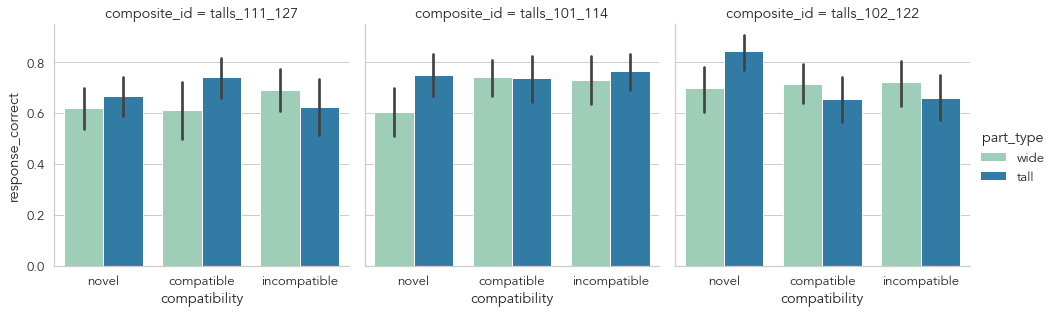

In [453]:
g = sns.catplot(data=df_zip,
                col="composite_id",
                y="response_correct", 
                hue="part_type",
                x="compatibility",
                palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

In [505]:
df_zip_item_compatibility_mean = df_zip.groupby(['gameID','composite_id','compatibility']).mean().reset_index()\
                                    .query('compatibility in ["compatible","incompatible"]')

In [507]:
ppt_item_compatibility_diffs = df_zip_item_compatibility_mean.groupby(['gameID','composite_id'])\
    [['response_correct','rt','compatibility']]

In [512]:
ppt_item_compatibility_diffs_comp_incomp = ppt_item_compatibility_diffs.apply(compatibility_diff).reset_index()

<AxesSubplot:xlabel='composite_id', ylabel='diff_rt'>

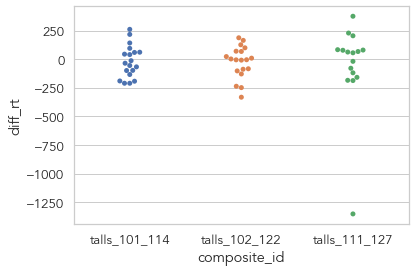

In [525]:
sns.swarmplot(data=ppt_item_compatibility_diffs_comp_incomp,
            y='diff_rt',
            x='composite_id',
            order=composite_order)

<AxesSubplot:xlabel='composite_id', ylabel='diff_response_correct'>

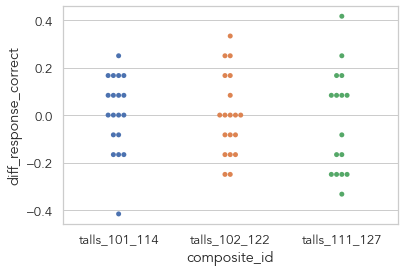

In [523]:
sns.swarmplot(data=ppt_item_compatibility_diffs_comp_incomp,
            y='diff_response_correct',
            x='composite_id',
            order=composite_order)

talls_101_114


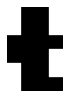

talls_102_122


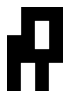

talls_111_127


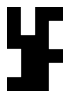

In [524]:
_ = [(print(stimID), show(toCompositeURL(stimID))) for stimID in composite_order]

## Block and condition

#### RT

Text(0.5, 1.0, 'response time by block and condition')

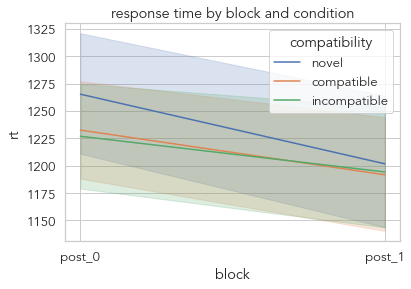

In [261]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="block",
                hue="compatibility",
            )
plt.title('response time by block and condition')

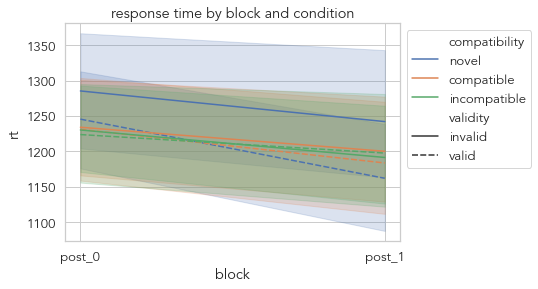

In [262]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="block",
                style="validity",
                hue="compatibility",
            )
plt.title('response time by block and condition')
plt.legend(bbox_to_anchor=(1,1))

The expectation was that rt would drop for compatible and (maybe) rise for incompatible.
But RT is higher for all conditions after the building task.
And even after practice they don't get as fast as they used to be.
What's going on?

What's the simplest explanation of this?
People get tired? But then they would continue to get worse.

People are taking longer to parse the objects?
But if so, they're doing it indiscriminantly- there is no difference between novel and built.

#### accuracy

Text(0.5, 1.0, 'accuracy time by block and condition')

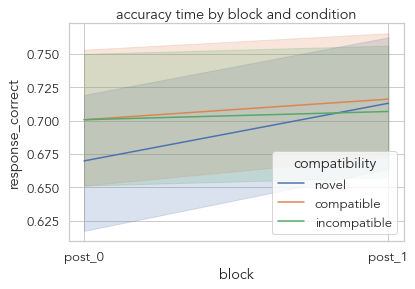

In [263]:
sns.lineplot(data = df_zip,
                y="response_correct", 
                x="block",
                hue="compatibility",
            )
plt.title('accuracy time by block and condition')

But they're more accurate.

### Stimuli

Does the same pattern hold across different stimulus 'rotations'?

There are three stimuli that we rotate into different positions.
Each of the three stims can be novel. And the other two stims can have wide parts built or tall parts built.


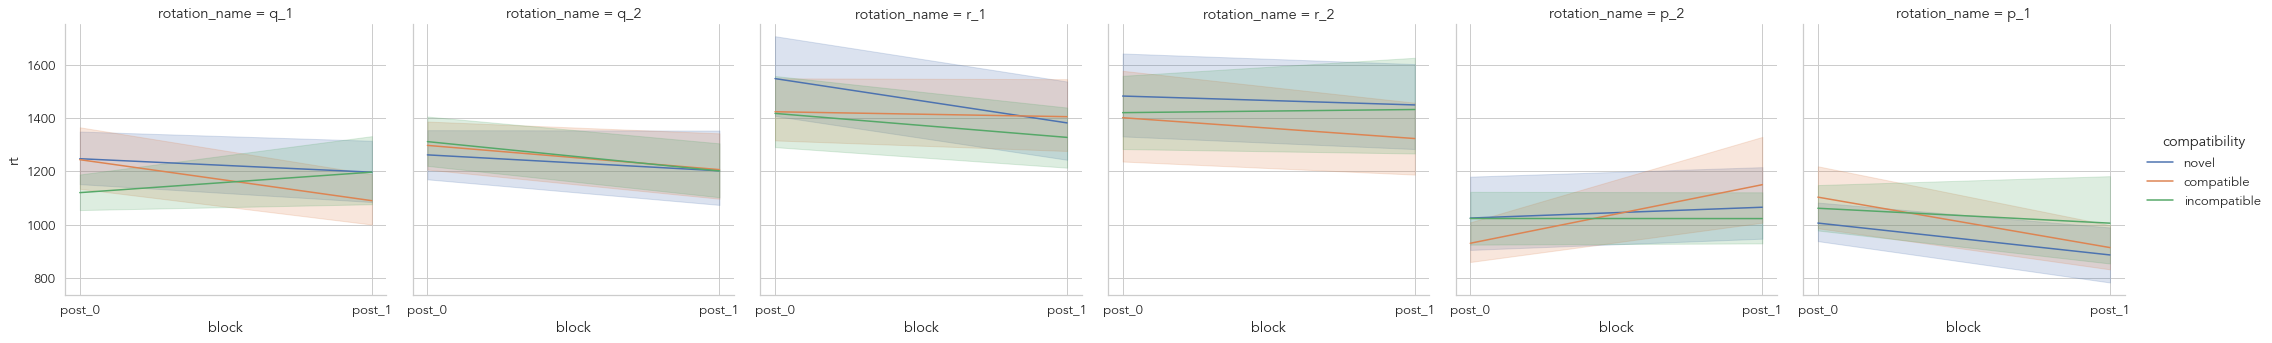

In [264]:
# response time by block and condition, separated by rotation 

f = sns.relplot(data = df_zip[(~df_zip.flagRT)],
                col = 'rotation_name',
                y="rt", 
                x="block",
                hue="compatibility",
                kind='line')

Text(0.5, 1.0, 'accuracy by block and condition')

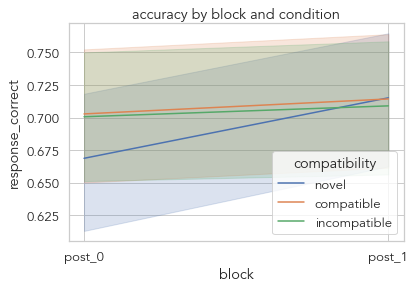

In [265]:
sns.lineplot(data = df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="block",
                hue="compatibility",
            )

plt.title('accuracy by block and condition')

Text(0.5, 1.0, 'accuracy by block and condition, separated by rotation')

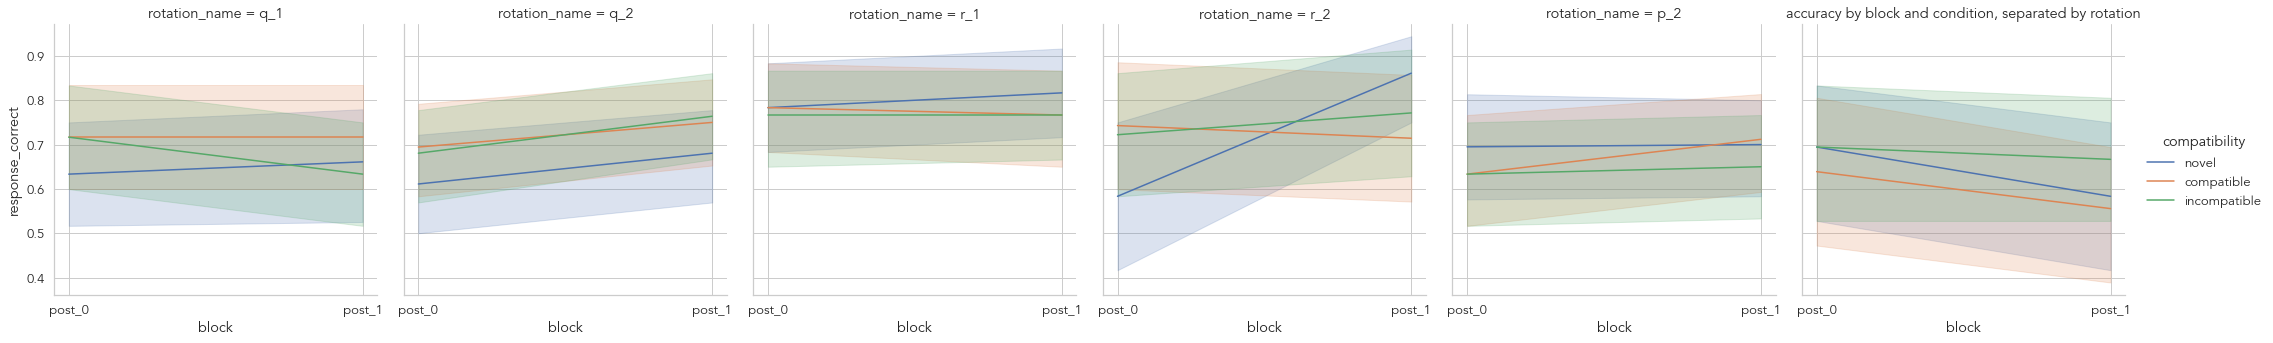

In [266]:
sns.relplot(data = df_zip[(~df_zip.flagRT)],
                col = 'rotation_name',
                y="response_correct", 
                x="block",
                hue="compatibility",
                kind='line')

plt.title('accuracy by block and condition, separated by rotation')

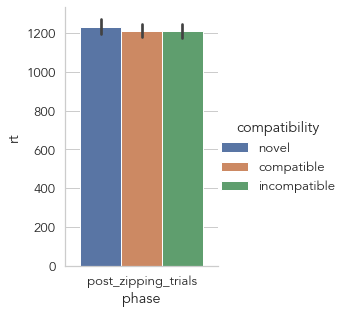

In [267]:
# We want to look at the interaction between phase, compatibility 

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="phase",
                hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()


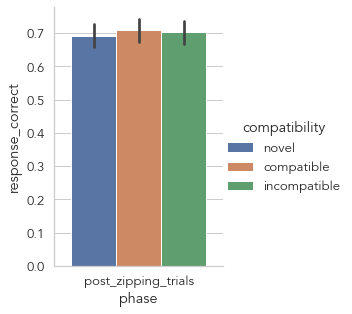

In [268]:
# We want to look at the interaction between phase, compatibility 

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="phase",
                hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

## zipping trials- participant level performance

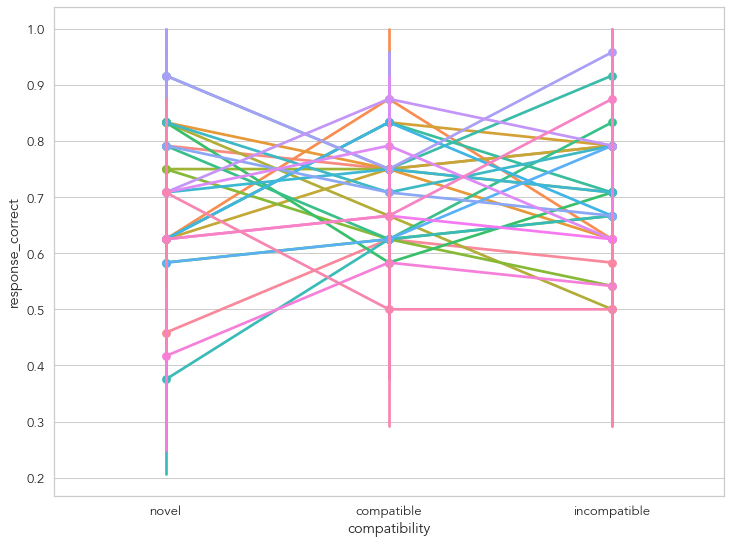

In [292]:
plt.figure(figsize=(12,9))

sns.pointplot(data = df_zip,
              y = 'response_correct',
              x = 'compatibility',
              hue = 'gameID')

plt.legend([],[], frameon=False)

In [301]:
df_zip['log_rt'] = np.log(df_zip.rt)

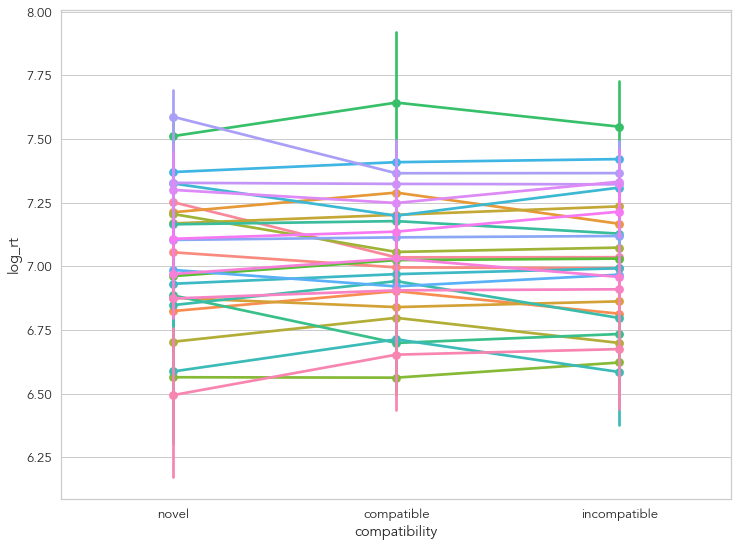

In [302]:
plt.figure(figsize=(12,9))

sns.pointplot(data = df_zip,
              y = 'log_rt',
              x = 'compatibility',
              hue = 'gameID')

plt.legend([],[], frameon=False)

Variation in participant performance

In [269]:
df_zip_ppt_mean = df_zip.groupby(['gameID']).mean().reset_index().merge(df_zip[['gameID','rotation_name']].groupby('gameID').last().reset_index(), 
                                                                        how='left',
                                                                        on='gameID')

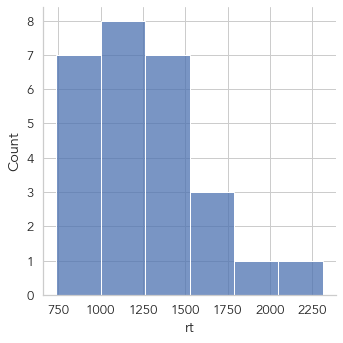

In [270]:
sns.displot(df_zip_ppt_mean, x='rt', kind='hist')

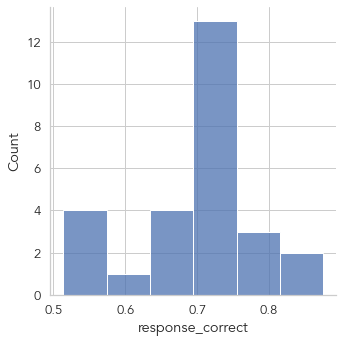

In [271]:
sns.displot(df_zip_ppt_mean, x='response_correct', kind='hist')

In [272]:
# anything that effects ppt level performance?

In [273]:
rotations = df_meta[['rotation', 'rotation_name']].groupby('rotation_name').first()
rotations = rotations.to_dict()

In [274]:
import requests

In [275]:
def show_stim(url, ax):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
#     plt.figure(figsize=(2,1))
    ax.imshow(img)
    ax.axis('off')
    
def display_rotation(rotation_name, 
                     url_stem = 'https://tower-4-block-unique-silhouettes-composite-silhouette-png.s3.amazonaws.com/tower_4_block_unique_silhouette_composites_silhouette_{}.png'):
    print(rotation_name)
    print('build_wide      build_tall      novel')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    show_stim(url_stem.format(rotations['rotation'][rotation_name]['build_wide']), ax1)
    show_stim(url_stem.format(rotations['rotation'][rotation_name]['build_tall']), ax2)
    show_stim(url_stem.format(rotations['rotation'][rotation_name]['novel']), ax3)


def show_part(part_id,
              verbose = False,
              url_stem = "https://lax-tower-4-block-unique-silhouettes-png.s3.amazonaws.com/tower_4_block_unique_silhouette_{}.png"):
    
    if verbose:
        print(part_id)
    response = requests.get(url_stem.format(part_id.split('_')[1]))
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize=(3,2))
    plt.imshow(img)
    plt.axis('off')
    
def show_part_subplot(part_id,
                      ax,
              url_stem = "https://lax-tower-4-block-unique-silhouettes-png.s3.amazonaws.com/tower_4_block_unique_silhouette_{}.png"):
    
    response = requests.get(url_stem.format(part_id.split('_')[1]))
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(part_id)


In [276]:
rotation_order = np.sort(df_zip_ppt_mean.rotation_name.unique())

<AxesSubplot:xlabel='rotation_name', ylabel='rt'>

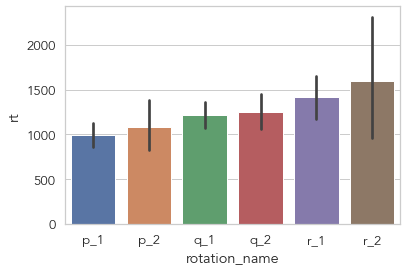

In [277]:
sns.barplot(data=df_zip_ppt_mean,
            y='rt',
            x='rotation_name',
            order = rotation_order)

<AxesSubplot:xlabel='rotation_name', ylabel='rt'>

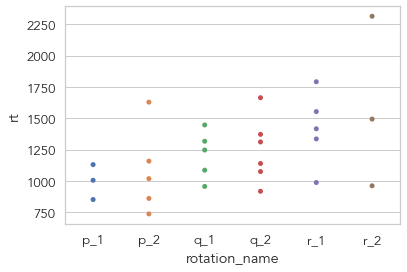

In [278]:
sns.swarmplot(data=df_zip_ppt_mean,
            y='rt',
            x='rotation_name',
            order = rotation_order)

<AxesSubplot:xlabel='rotation_name', ylabel='response_correct'>

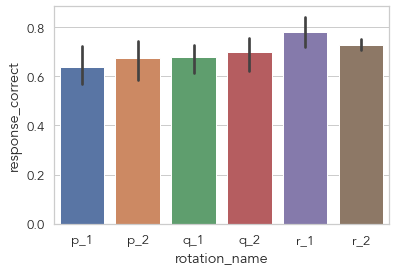

In [279]:
sns.barplot(data=df_zip_ppt_mean,
            y='response_correct',
            x='rotation_name',
            order = rotation_order)

<AxesSubplot:xlabel='rotation_name', ylabel='response_correct'>

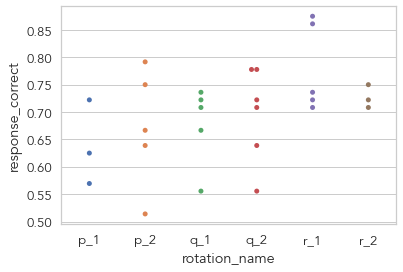

In [280]:
sns.swarmplot(data=df_zip_ppt_mean,
            y='response_correct',
            x='rotation_name',
            order = rotation_order)

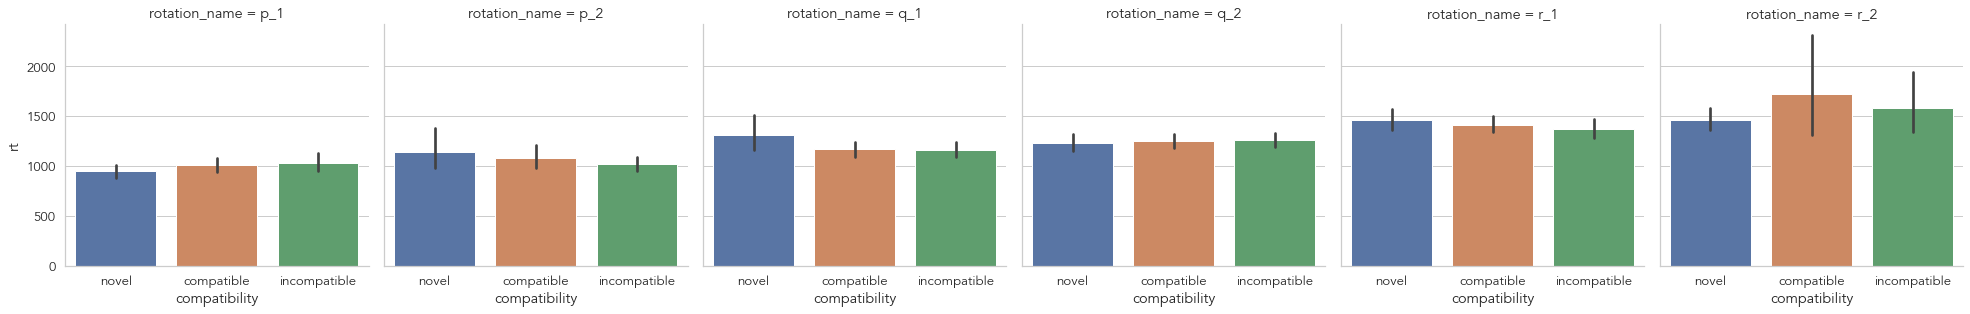

In [464]:
g = sns.catplot(data=df_zip,
                col="rotation_name",
                col_order=rotation_order,
                y="rt", 
#                 hue="part_type",
                x="compatibility",
#                 palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

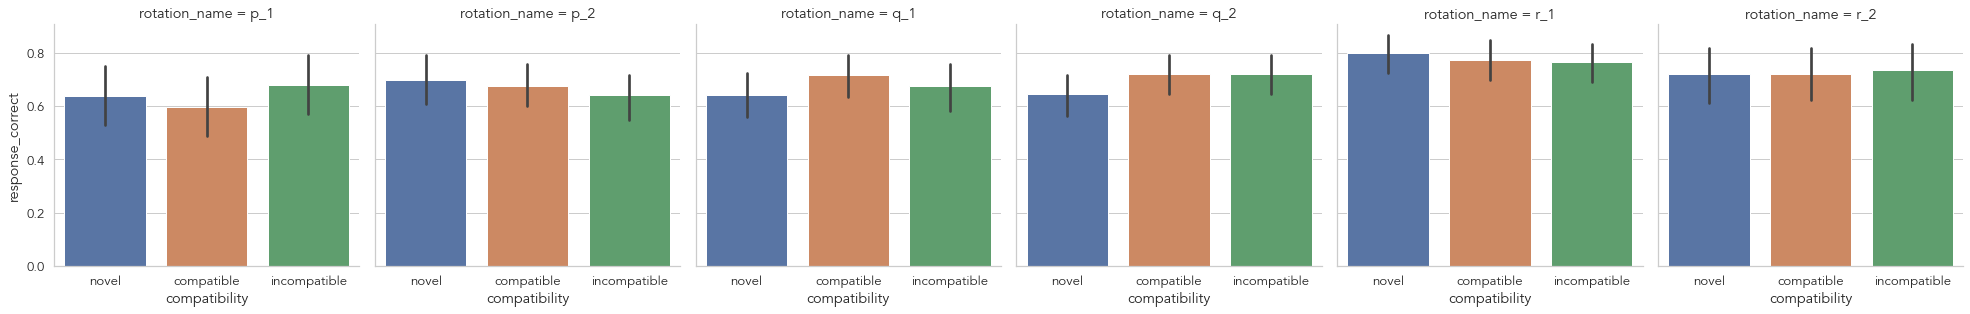

In [465]:
g = sns.catplot(data=df_zip,
                col="rotation_name",
                col_order=rotation_order,
                y="response_correct", 
#                 hue="part_type",
                x="compatibility",
#                 palette="YlGnBu",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=1)
plt.show()

p_1
build_wide      build_tall      novel


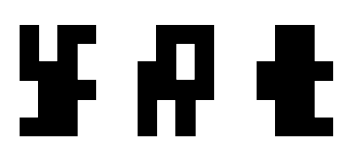

In [281]:
display_rotation(rotation_order[0])

p_2
build_wide      build_tall      novel


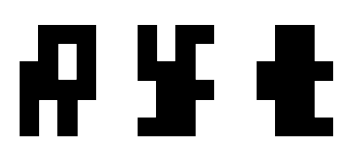

In [282]:
display_rotation(rotation_order[1])

q_1
build_wide      build_tall      novel


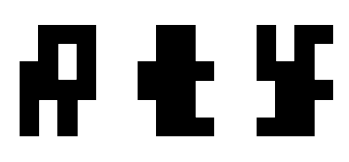

In [283]:
display_rotation(rotation_order[2])

q_2
build_wide      build_tall      novel


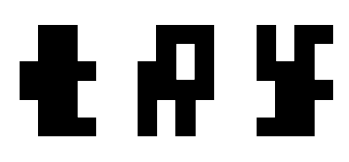

In [284]:
display_rotation(rotation_order[3])

r_1
build_wide      build_tall      novel


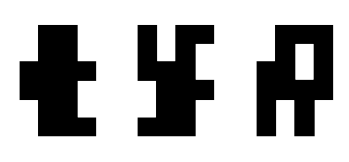

In [285]:
display_rotation(rotation_order[4])

r_2
build_wide      build_tall      novel


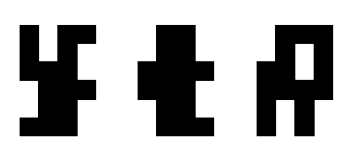

In [286]:
display_rotation(rotation_order[5])

<AxesSubplot:xlabel='rt', ylabel='response_correct'>

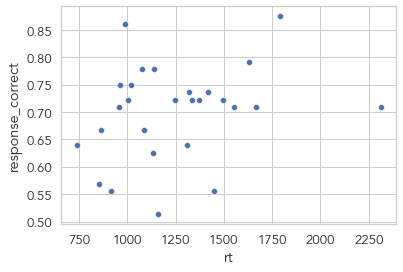

In [287]:
# looking for speed accuracy trade-off

sns.scatterplot(data = df_zip_ppt_mean,
                x = 'rt',
                y = 'response_correct')

# Within PPT differences

Between compatible and incompatible

In [335]:
df_zip_compatibility_mean = df_zip.groupby(['gameID','compatibility']).mean().reset_index()

In [336]:
ppt_compatibility_diffs = df_zip_compatibility_mean.groupby(['gameID'])[['response_correct','rt','compatibility']]

In [337]:
ppt_compatibility_diffs_comp_incomp = ppt_compatibility_diffs.apply(compatibility_diff)

In [338]:
ppt_compatibility_diffs_nov_comp = \
    ppt_compatibility_diffs.apply(compatibility_diff, compatibilities=['novel','incompatible'])

Text(0.5, 1.0, 'difference between compatible and incompatible')

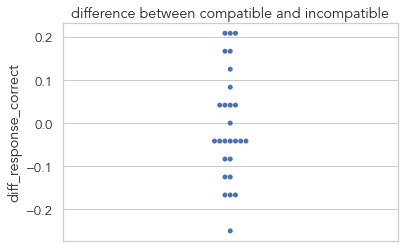

In [359]:
sns.swarmplot(data = ppt_compatibility_diffs_comp_incomp,
            y = 'diff_response_correct')

plt.title('difference between compatible and incompatible')

Text(0.5, 1.0, 'difference between compatible and incompatible')

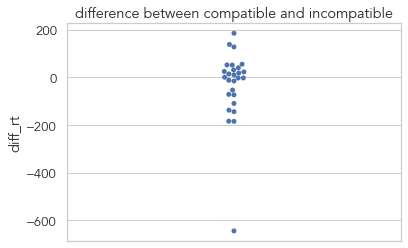

In [360]:
sns.swarmplot(data = ppt_compatibility_diffs_comp_incomp,
            y = 'diff_rt')

plt.title('difference between compatible and incompatible')

Text(0.5, 1.0, 'difference between compatible and incompatible')

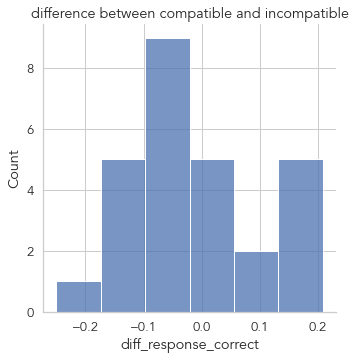

In [353]:
sns.displot(data = ppt_compatibility_diffs_comp_incomp,
            x = 'diff_response_correct')

plt.title('difference between compatible and incompatible')

Text(0.5, 1.0, 'difference between compatible and incompatible')

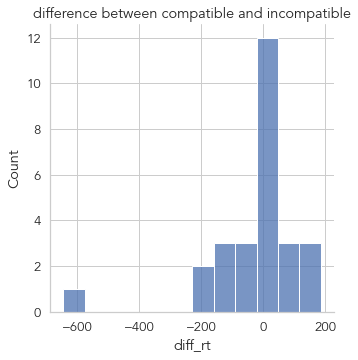

In [354]:
sns.displot(data = ppt_compatibility_diffs_comp_incomp,
            x = 'diff_rt')

plt.title('difference between compatible and incompatible')

Text(0.5, 1.0, 'difference between novel and incompatible')

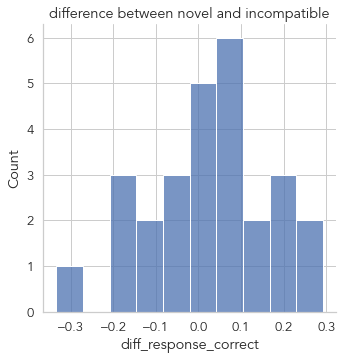

In [355]:
sns.displot(data = ppt_compatibility_diffs_nov_comp,
            x = 'diff_response_correct',
            bins=10)

plt.title('difference between novel and incompatible')

Text(0.5, 1.0, 'difference between novel and incompatible')

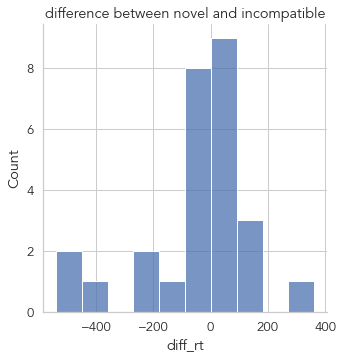

In [356]:
sns.displot(data = ppt_compatibility_diffs_nov_comp,
            x = 'diff_rt',
            bins=10)

plt.title('difference between novel and incompatible')

Text(0.5, 1.0, 'difference between novel and incompatible')

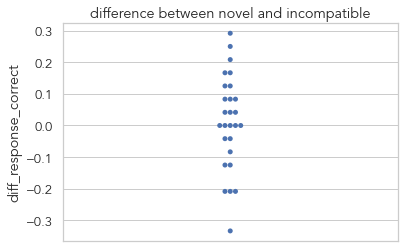

In [361]:
sns.swarmplot(data = ppt_compatibility_diffs_nov_comp,
            y = 'diff_response_correct')

plt.title('difference between novel and incompatible')

Text(0.5, 1.0, 'difference between novel and incompatible')

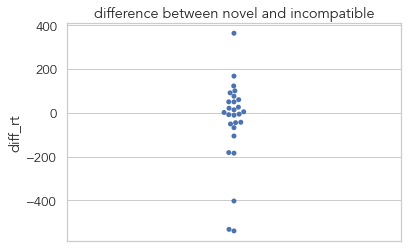

In [362]:
sns.swarmplot(data = ppt_compatibility_diffs_nov_comp,
            y = 'diff_rt')

plt.title('difference between novel and incompatible')

## Differences between conditions by mean task performance

In [412]:
df_zip_diffs_nov_comp = ppt_compatibility_diffs_nov_comp.merge(df_zip_ppt_mean, on='gameID')
df_zip_diffs_comp_incomp = ppt_compatibility_diffs_comp_incomp.merge(df_zip_ppt_mean, on='gameID')

In [416]:
df_zip_diffs_comp_incomp

gameID  diff_response_correct  \
0   0581-6a290675-ac2d-4446-a181-3d3e545c534e              -0.041667   
1   1199-27a29656-1dbe-4aeb-9305-8dbd12e55839              -0.166667   
2   1711-d5c126e7-318a-4ebd-bccf-e865f5c0e2e1              -0.041667   
3   1945-8f8714ae-b89b-4ca0-b013-3373fc5763da               0.208333   
4   2002-0d32a6aa-c1d1-4585-aee2-b0e79561065d               0.083333   
5   2180-6e340123-d0e2-47e1-a832-4a0c061db44b               0.041667   
6   2251-16ae277d-65bc-4fcc-85d2-5976fc60fdd6              -0.250000   
7   2497-d16fe438-1b10-4726-b497-72abb758767b              -0.166667   
8   2712-3ef02430-77ed-4234-9278-5b5afb277889               0.041667   
9   2722-e9ac1150-6375-4d66-be29-19cec364601f               0.166667   
10  3242-3ef510a0-a88a-4469-8644-c313768b8e12              -0.041667   
11  3824-1645087e-8b8d-4f26-82a3-1b2b04bfca3b              -0.125000   
12  3944-608b2a6c-e1bc-4a9e-b62d-40311ec10668              -0.041667   
13  4584-bbb653af-a114-4cd0-afc1-62cda8a3b118              -0.083333   
14  4628-3e0312f5-9804-479a-b877-7cfd37b43dc5              -0.166667   
15  4773-f620c738-7010-4b5d-998b-76907f7dd360               0.166667   
16  4822-ca43fbc6-d987-42ea-8d07-b10734a15745              -0.041667   
17  5333-28aa563c-5430-4783-b34e-a6df0d7b5c0a               0.208333   
18  5388-1ed25a27-e3ca-46fb-a3bc-35dc2b3fbea3               0.125000   
19  5766-610e95c0-a258-4df0-957d-1740d229a606               0.041667   
20  6442-e435966a-6e09-47ab-a88f-76d59919ade7              -0.041667   
21  6940-1c19ec14-112f-428a-b05c-9c7dc11e4004               0.000000   
22  7607-de5babf9-9205-4178-a5ed-8f4671bd7c04              -0.125000   
23  8208-2927441a-c7dd-4370-a33f-ce59e7cac595               0.041667   
24  8323-1f14a318-9b9e-4ca8-b136-9ee8d411958e              -0.041667   
25  9165-a89fbce3-5cb1-4b1e-8ef8-b546d032ad92              -0.083333   
26  9839-2624e9ad-e118-4082-95a1-7254dd7e29ec               0.208333   

       diff_rt        index  trial_start_time  trial_finish_time           rt  \
0   128.412500  2329.888889      1.660176e+12       1.660176e+12  1311.555556   
1   138.920833  2197.236111      1.660176e+12       1.660176e+12  1553.652778   
2    25.312500   917.541667      1.658775e+12       1.658775e+12   962.265278   
3    10.770833  2621.375000      1.660177e+12       1.660177e+12  1006.277778   
4    18.629167  2125.875000      1.660176e+12       1.660176e+12  1075.838889   
5    40.770833  1379.930556      1.660174e+12       1.660174e+12  1130.972222   
6   -71.041667   821.180556      1.658775e+12       1.658775e+12   957.104167   
7   -73.345833  1067.625000      1.658775e+12       1.658775e+12   861.451389   
8    52.695833  1023.736111      1.658775e+12       1.658775e+12  1372.100000   
9    55.733333  1939.930556      1.660176e+12       1.660176e+12  1086.694444   
10  -11.720833  2066.236111      1.660176e+12       1.660176e+12  1247.208333   
11 -109.312500   950.791667      1.658775e+12       1.658775e+12  1416.456944   
12    0.895833  1269.888889      1.660174e+12       1.660174e+12  1317.193056   
13 -144.079167  2177.972222      1.660176e+12       1.660176e+12  1628.733333   
14   14.716667  1999.166667      1.660176e+12       1.660176e+12  1664.191667   
15 -183.920833  1728.388889      1.660175e+12       1.660175e+12   988.202778   
16  -15.162500   647.500000      1.658541e+12       1.658541e+12  1446.990278   
17   -2.233333  2331.416667      1.660176e+12       1.660176e+12  1791.444444   
18 -645.591667  1392.916667      1.660174e+12       1.660174e+12  2313.429167   
19 -184.725917  1746.458333      1.660175e+12       1.660175e+12   918.305403   
20 -137.687500  2356.666667      1.660176e+12       1.660176e+12  1158.770833   
21   23.329167  2699.500000      1.660190e+12       1.660190e+12   852.715278   
22  -53.045833  1572.083333      1.660175e+12       1.660175e+12  1335.891667   
23   -2.033333   723.500000      1.658542e+12       1.658542e+12  1140.027778 

### Novel to incompatible

Text(0.5, 1.0, 'difference between novel and incompatible by average task performance')

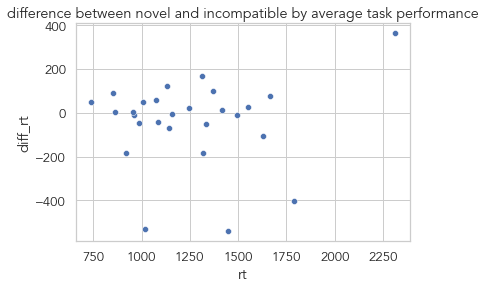

In [420]:
sns.scatterplot(data = df_zip_diffs_nov_comp,
                x = 'rt',
                y = 'diff_rt')

plt.title('difference between novel and incompatible by average task performance')

Text(0.5, 1.0, 'difference between novel and incompatible by average task performance')

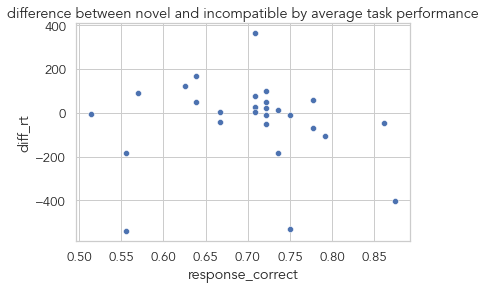

In [421]:
sns.scatterplot(data = df_zip_diffs_nov_comp,
                x = 'response_correct',
                y = 'diff_rt')

plt.title('difference between novel and incompatible by average task performance')

Text(0.5, 1.0, 'difference between novel and incompatible by average task performance')

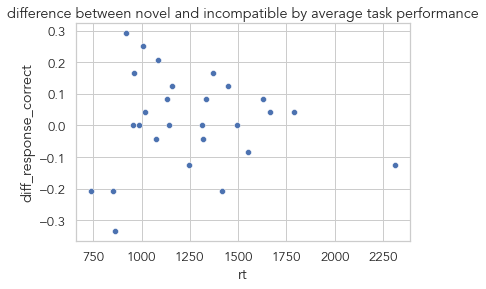

In [423]:
sns.scatterplot(data = df_zip_diffs_nov_comp,
                x = 'rt',
                y = 'diff_response_correct')

plt.title('difference between novel and incompatible by average task performance')

Text(0.5, 1.0, 'difference between novel and incompatible by average task performance')

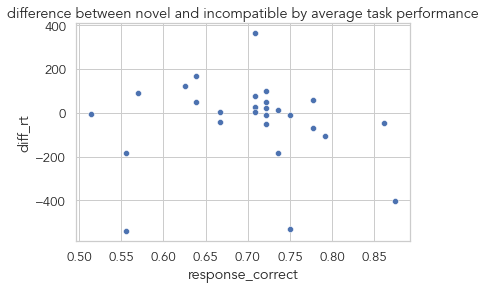

In [418]:
sns.scatterplot(data = df_zip_diffs_nov_comp,
                x = 'response_correct',
                y = 'diff_response_correct')

plt.title('difference between novel and incompatible by average task performance')

### compatible to incompatible

Text(0.5, 1.0, 'difference between compatible and incompatible by average task performance')

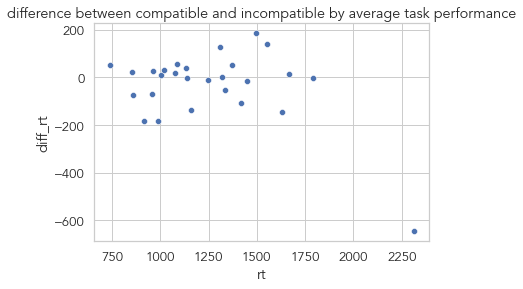

In [424]:
sns.scatterplot(data = df_zip_diffs_comp_incomp,
                x = 'rt',
                y = 'diff_rt')

plt.title('difference between compatible and incompatible by average task performance')

Text(0.5, 1.0, 'difference between compatible and incompatible by average task performance')

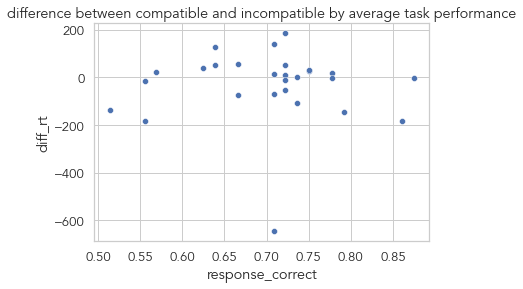

In [425]:
sns.scatterplot(data = df_zip_diffs_comp_incomp,
                x = 'response_correct',
                y = 'diff_rt')

plt.title('difference between compatible and incompatible by average task performance')

Text(0.5, 1.0, 'difference between compatible and incompatible by average task performance')

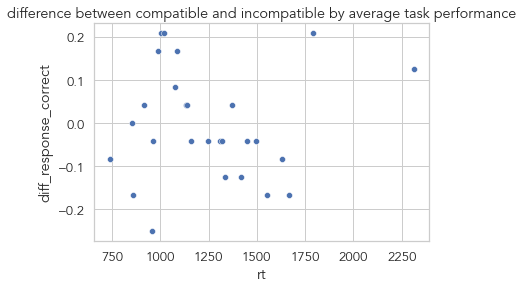

In [426]:
sns.scatterplot(data = df_zip_diffs_comp_incomp,
                x = 'rt',
                y = 'diff_response_correct')

plt.title('difference between compatible and incompatible by average task performance')

Text(0.5, 1.0, 'difference between compatible and incompatible by average task performance')

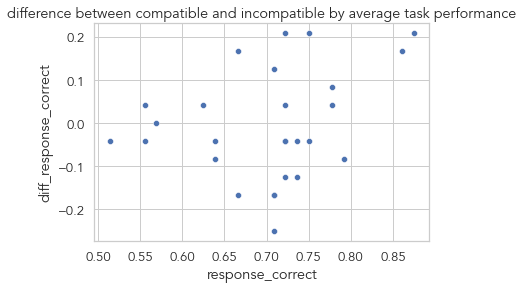

In [427]:
sns.scatterplot(data = df_zip_diffs_comp_incomp,
                x = 'response_correct',
                y = 'diff_response_correct')

plt.title('difference between compatible and incompatible by average task performance')

### Differences in conditions by rotation

Text(0.5, 1.0, 'difference between compatible and incompatible by average task performance')

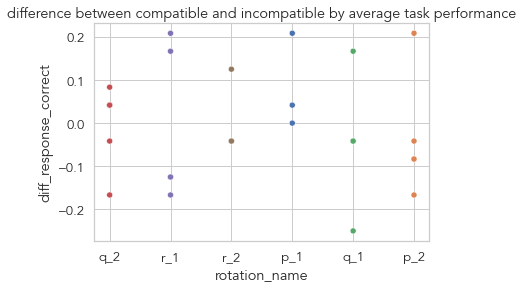

In [571]:
sns.scatterplot(data = df_zip_diffs_comp_incomp,
                x = 'rotation_name',
                y = 'diff_response_correct',
                hue = 'rotation_name',
                hue_order = rotation_order,
                legend=False)

plt.title('difference between compatible and incompatible by average task performance')

Text(0.5, 1.0, 'difference between compatible and incompatible by average task performance')

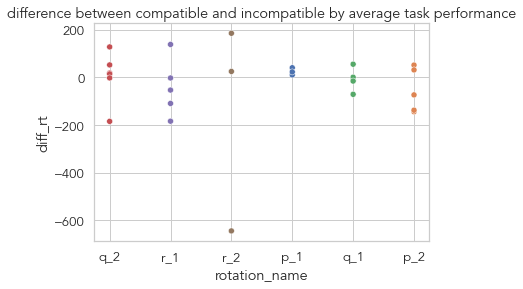

In [572]:
sns.scatterplot(data = df_zip_diffs_comp_incomp,
                x = 'rotation_name',
                y = 'diff_rt',
                hue = 'rotation_name',
                hue_order = rotation_order,
                legend=False)

plt.title('difference between compatible and incompatible by average task performance')

### Part type

/Users/will/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='response_correct', ylabel='Density'>

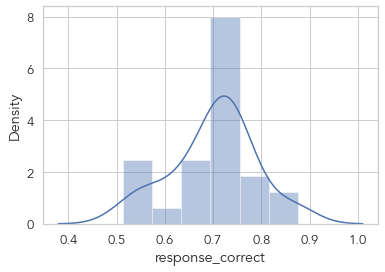

In [601]:
sns.distplot(df_zip_ppt_mean.response_correct)

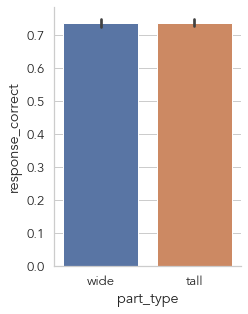

In [51]:
g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="part_type",
#                 hue="compatibility",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

### Stimulus

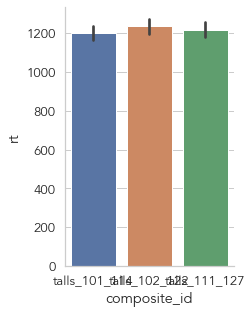

In [604]:
# Is one of the stims easier across the board?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="rt", 
                x="composite_id",
#                 hue="part_type",
                order=composite_order,
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

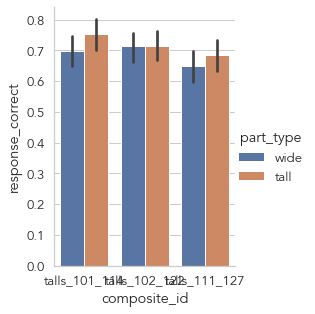

In [607]:
# Are any of the stims easier in one direction?

g = sns.catplot(data=df_zip[(~df_zip.flagRT)],
                y="response_correct", 
                x="composite_id",
                order=composite_order,
                hue="part_type",
                dodge=True,
                kind="bar",
                height=4.6,
                aspect=0.8)
plt.show()

## d'

In [611]:
from scipy.stats import norm

Z = norm.ppf

In [612]:
def d_primes(df):
    
    # find hit rate H, proportion of yes trials with response M
    #df_zip[(df_zip.response=='m') & (df_zip.validity == 'valid')]
    yes_trials = df[df.validity=='valid']
    
    H = len(yes_trials[yes_trials.response==df[df.validity=='valid']['expected_response']])/ len(yes_trials)
    
    # replace hit rates to avoid inf d-prime
#     half_hit = 0.5 / len(yes_trials)
    if H == 1: 
#         H = 1 - half_hit
        H = 0.9999
    if H == 0: 
#         H = half_hit
        H = 0.0001
    

    # find false alarm rate F, proportion of no trials with response M
    no_trials = df[df.validity=='invalid']
    
    F = len(no_trials[no_trials.response!=df[df.validity=='invalid']['expected_response']])/ len(no_trials)
    
    # replace hit rates to avoid inf d-prime
#     half_fa = 0.5 / len(no_trials)
    if F == 1: 
#         F = 1 - half_fa
        F = 0.9999
    if F == 0: 
#         F = half_fa
        F = 0.0001
    
    
    d_prime = Z(H) - Z(F)
    
    return d_prime

In [613]:
d_blocks = df_zip[~df_zip.flagRT].groupby(['gameID','block']).apply(d_primes).reset_index()
d_blocks = d_blocks.rename(columns = {0: 'd_prime'})

<AxesSubplot:xlabel='block', ylabel='d_prime'>

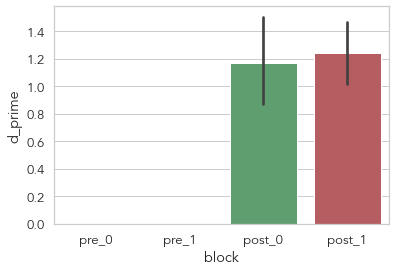

In [614]:
sns.barplot(data = d_blocks,
            y = 'd_prime',
            x = 'block',
            order=block_order)

In [615]:
d_phase = df_zip[~df_zip.flagRT].groupby(['gameID','phase']).apply(d_primes).reset_index()
d_phase = d_phase.rename(columns = {0: 'd_prime'})

<AxesSubplot:xlabel='phase', ylabel='d_prime'>

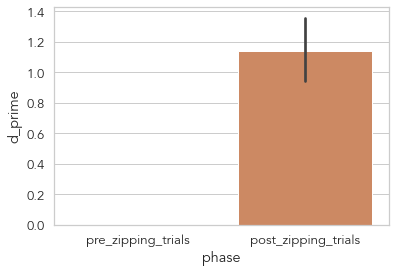

In [616]:
sns.barplot(data = d_phase,
            y = 'd_prime',
            x = 'phase',
            order = phase_order)

In [617]:
d_phase_compatibility = df_zip[~df_zip.flagRT].groupby(['gameID','phase','compatibility']).apply(d_primes).reset_index()
d_phase_compatibility = d_phase_compatibility.rename(columns = {0: 'd_prime'})

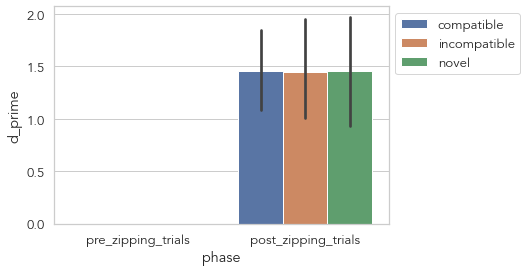

In [623]:
sns.barplot(data = d_phase_compatibility,
            y = 'd_prime',
            x = 'phase',
            hue = 'compatibility',
            order = phase_order)
plt.legend(bbox_to_anchor=(1,1))

<AxesSubplot:xlabel='compatibility', ylabel='d_prime'>

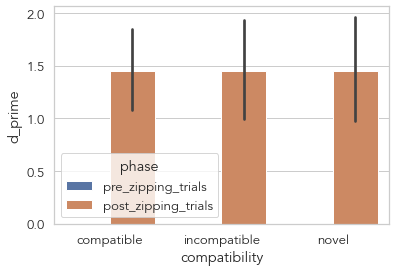

In [619]:
sns.barplot(data = d_phase_compatibility,
            y = 'd_prime',
            hue = 'phase',
            x = 'compatibility',
            hue_order = phase_order)

In [620]:
d_block_compatibility = df_zip[~df_zip.flagRT].groupby(['gameID','block','compatibility']).apply(d_primes).reset_index()
d_block_compatibility = d_block_compatibility.rename(columns = {0: 'd_prime'})

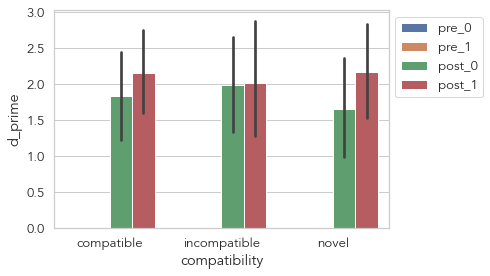

In [621]:
sns.barplot(data = d_block_compatibility,
            y = 'd_prime',
            hue = 'block',
            x = 'compatibility',
            hue_order = block_order)
plt.legend(bbox_to_anchor=(1,1))

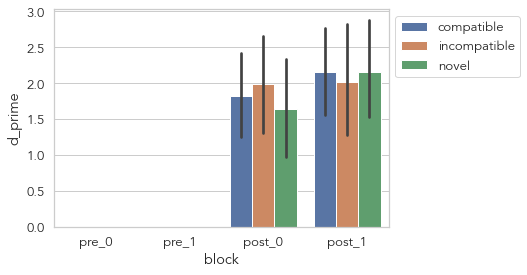

In [622]:
sns.barplot(data = d_block_compatibility,
            y = 'd_prime',
            x = 'block',
            hue = 'compatibility',
            order = block_order)
plt.legend(bbox_to_anchor=(1,1))

## Building Trials

In [375]:
df_build['trial_duration'] = df_build.timeAbsolute - df_build.trial_start_time
df_build['trial_duration_min'] =  df_build['trial_duration'] / (60 * 1000)

### whole trials

In [376]:
ppts_left = list(df_zip.gameID.unique())

In [377]:
df_build = df_build[df_build.gameID.isin(ppts_left)]

In [378]:
df_ppt_info = df_zip[['gameID', 'rotation_name']].groupby('gameID').first()

In [379]:
df_build_means = df_build.groupby('gameID').mean().reset_index().merge(df_ppt_info, how='left', on='gameID')
df_build_phase_means = df_build.groupby(['gameID','rep']).mean().reset_index().merge(df_ppt_info, how='left', on='gameID')
df_build_part_means = df_build.groupby(['gameID','chunk_id']).mean().reset_index().merge(df_ppt_info, how='left', on='gameID')

In [380]:
df_build_phase_means

gameID  rep  timeAbsolute  \
0    0581-6a290675-ac2d-4446-a181-3d3e545c534e    0  1.660175e+12   
1    0581-6a290675-ac2d-4446-a181-3d3e545c534e    1  1.660176e+12   
2    0581-6a290675-ac2d-4446-a181-3d3e545c534e    2  1.660176e+12   
3    0581-6a290675-ac2d-4446-a181-3d3e545c534e    3  1.660176e+12   
4    1199-27a29656-1dbe-4aeb-9305-8dbd12e55839    0  1.660175e+12   
..                                         ...  ...           ...   
103  9165-a89fbce3-5cb1-4b1e-8ef8-b546d032ad92    3  1.660174e+12   
104  9839-2624e9ad-e118-4082-95a1-7254dd7e29ec    0  1.660174e+12   
105  9839-2624e9ad-e118-4082-95a1-7254dd7e29ec    1  1.660174e+12   
106  9839-2624e9ad-e118-4082-95a1-7254dd7e29ec    2  1.660174e+12   
107  9839-2624e9ad-e118-4082-95a1-7254dd7e29ec    3  1.660174e+12   

     timeRelative  trial_start_time  relative_time  n_resets  trial_index  \
0        71372.25      1.660175e+12       16162.00      0.25          4.5   
1       142439.25      1.660176e+12       15106.50      0.25          8.5   
2       212196.75      1.660176e+12       13441.00      0.00         12.5   
3       278197.00      1.660176e+12       14364.25      0.00         16.5   
4       182851.75      1.660175e+12       16134.50      0.00          4.5   
..            ...               ...            ...       ...          ...   
103     273196.00      1.660174e+12        8886.75      0.00         16.5   
104     190427.00      1.660173e+12       34682.00      0.25          4.5   
105     293171.50      1.660174e+12       56373.25      0.50          8.5   
106     478933.00      1.660174e+12       10865.00      0.00         12.5   
107     548034.75      1.660174e+12       14522.75      0.00         16.5   

     time_elapsed  trial_num  trial_duration  trial_duration_min rotation_name  
0        66886.25        1.5        16161.75            0.269363           q_2  
1       138007.00        5.5        15106.25            0.251771           q_2  
2       207840.50        9.5        13441.00            0.224017           q_2  
3       273834.00       13.5        14364.00            0.239400           q_2  
4       183518.50        1.5        16134.25            0.268904           r_1  
..            ...        ...             ...                 ...           ...  
103     273772.25       13.5         8886.50            0.148108           p_2  
104     190593.75        1.5        34681.75            0.578029           p_2  
105     293433.25        5.5        56372.75            0.939546           p_2  
106     479252.50        9.5        10864.50            0.181075           p_2  
107     548419.50       13.5        14522.50            0.242042           p_2  

[108 rows x 13 columns]

### Resets

In [381]:
# what is the overall variation in build performance?

Text(0.5, 1.0, 'mean number of resets across trials')

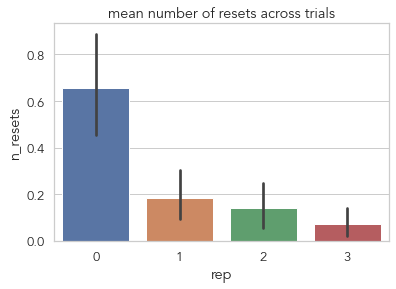

In [382]:
sns.barplot(data = df_build_phase_means,
            y = 'n_resets',
            x = 'rep')
plt.title('mean number of resets across trials')

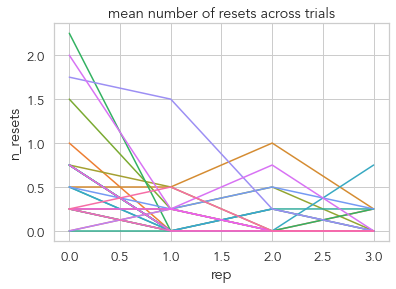

In [383]:
sns.lineplot(data = df_build_phase_means,
            y = 'n_resets',
            x = 'rep',
            hue= 'gameID')
plt.title('mean number of resets across trials')
plt.legend([],[], frameon=False)

Text(0.5, 1.0, 'mean number of resets in trial for each ppt')

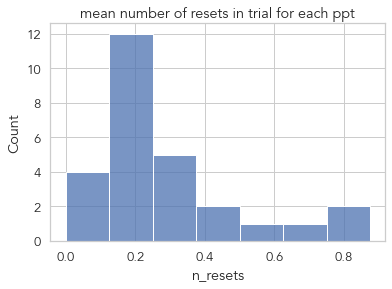

In [384]:
sns.histplot(df_build_means.n_resets)
plt.title('mean number of resets in trial for each ppt')

### Build time

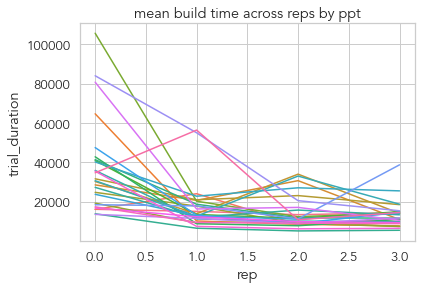

In [385]:
sns.lineplot(data = df_build_phase_means,
            y = 'trial_duration',
            x = 'rep',
            hue= 'gameID')
plt.title('mean build time across reps by ppt')
plt.legend([],[], frameon=False)

Text(0.5, 1.0, 'mean build time across reps')

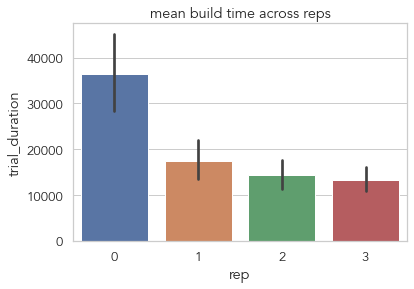

In [386]:
sns.barplot(data = df_build_phase_means,
            y = 'trial_duration',
            x = 'rep')

plt.title('mean build time across reps')

Text(0.5, 1.0, 'mean ppt build time')

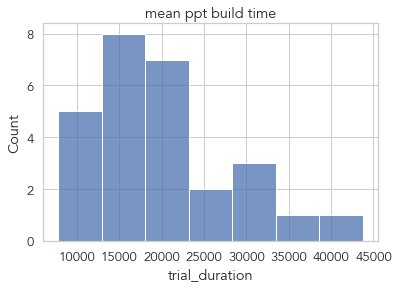

In [387]:
# what's the variation across people?

sns.histplot(data = df_build_means,
            x = 'trial_duration')

plt.title('mean ppt build time')

### What explains this variation?

#### Are some chunks harder than others?

In [388]:
three_composites = pd.read_csv('../../stimuli/block_utils/ambiguous/df_stims_pre_post_run_0.csv')

In [389]:
three_composites[['tower_id_tall','tower_A_tall_id','tower_B_tall_id','tower_A_wide_id','tower_B_wide_id']]

tower_id_tall tower_A_tall_id tower_B_tall_id tower_A_wide_id  \
0  talls_111_127        tall_111        tall_127        wide_011   
1  talls_102_122        tall_102        tall_122        wide_025   
2  talls_101_114        tall_101        tall_114        wide_019   

  tower_B_wide_id  
0        wide_015  
1        wide_010  
2        wide_008

In [396]:
# ordered first by tall/ wide, then by composite in which they appear
part_order_tall_wide = \
              ['tall_111', 'tall_127',
              'tall_102', 'tall_122',
              'tall_101', 'tall_114',
              'wide_011', 'wide_015',
              'wide_025', 'wide_010',
              'wide_019', 'wide_008']

# ordered first by composite in which they appear, then by tall/ wide
part_order_composites = \
              ['tall_111', 'tall_127',
               'wide_011', 'wide_015',
               'tall_102', 'tall_122',
               'wide_025', 'wide_010',
               'tall_101', 'tall_114',
               'wide_019', 'wide_008']

part_order = part_order_composites

Text(0.5, 1.0, 'mean number of resets across parts')

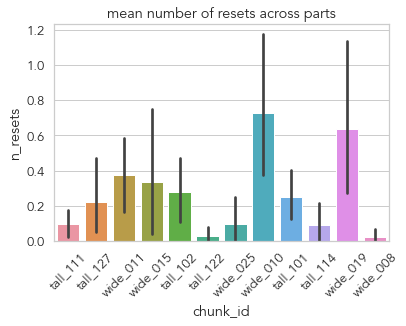

In [397]:
plt.figure(figsize = (6,4))
sns.barplot(data = df_build_part_means,
            y = 'n_resets',
            x = 'chunk_id',
            order = part_order)
plt.xticks(rotation = 45)
plt.title('mean number of resets across parts')

Text(0.5, 1.0, 'mean build time across parts')

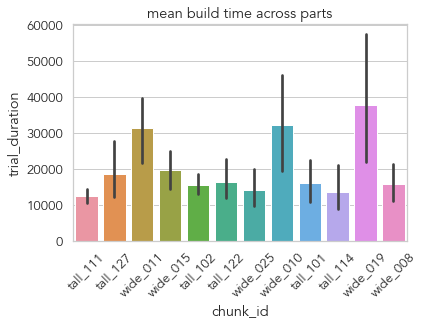

In [398]:
plt.figure(figsize = (6,4))
sns.barplot(data = df_build_part_means,
            y = 'trial_duration',
            x = 'chunk_id',
            order = part_order)
plt.xticks(rotation = 45)
plt.title('mean build time across parts')

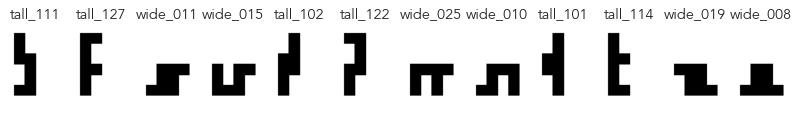

In [399]:
fig, axs = plt.subplots(1, 12, figsize=(14,5))

for i, part in enumerate(part_order):
    show_part_subplot(part, axs[i])

#### Rotation

Text(0.5, 1.0, 'mean build time across rotations')

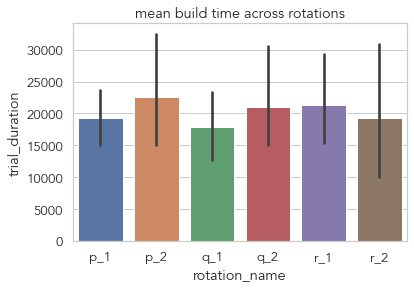

In [400]:
sns.barplot(data = df_build_phase_means,
            y = 'trial_duration',
            x = 'rotation_name',
            order=rotation_order)

plt.title('mean build time across rotations')

In [401]:
df_meta[['rotation_name','rotation']].iloc[3]['rotation']

{'build_wide': 'talls_111_127',
 'build_tall': 'talls_101_114',
 'novel': 'talls_102_122'}

### How does building performance relate to zipping performance?

Do the better builders have larger pre-post differences? (specifically for compatible trials?)
Do the worse builders have larger pre-post differences? (specifically for compatible trials?)
Do the most improving builders have larger pre-post differences? (specifically for compatible trials?)

In [402]:
df_build_means_condensed = df_build_means[['gameID', 'trial_duration', 'n_resets']].rename(columns = {'trial_duration':'build_duration'})

In [403]:
# need a dataframe with mean building performance and diffs.
df_build_zip_performance =  ppt_phase_compatibility_diffs.merge(df_build_means_condensed)

NameError: name 'ppt_phase_compatibility_diffs' is not defined

In [ ]:
sns.swarmplot(data = df_build_zip_performance,
            hue = 'build_duration',
            y = 'diff_response_correct',
            x = 'compatibility')
# plt.legend([],[], frameon=False)
plt.legend(bbox_to_anchor=(1,1))


In [ ]:
sns.swarmplot(data = df_build_zip_performance,
            hue = 'build_duration',
            y = 'diff_rt',
            x = 'compatibility')
# plt.legend([],[], frameon=False)
plt.ylim(-2000,2500)
plt.legend(bbox_to_anchor=(1,1))

In [ ]:
sns.relplot(data = df_build_zip_performance,
                col = 'compatibility',
                y = 'diff_response_correct',
                x = 'build_duration')

### individual block placements

In [ ]:
df_block_placements

### resets

In [60]:
df_resets.columns

Index(['_id', 'experimentName', 'iterationName', 'workerID', 'gameID',
       'studyLocation', 'n_blocks_when_reset', 'trial_start_time',
       'relative_time', 'datatype', 'stimURL', 'stimulus', 'stimId',
       'chunk_id', 'rep', 'condition', 'chunk_type', 'n_block', 'n_resets'],
      dtype='object')

In [61]:
import blockworld_utils as utils

In [62]:
# [utils.draw_world(utils.worldify(w)) for w in df_block_placements.blocks]

In [99]:
df_survey

NameError: name 'df_survey' is not defined

In [64]:
df_zip.to_csv('../results/zipping/csv/pilot_0_zipping_trials.csv')

In [65]:
!! open .

[]